## Section 0: Executive Summary

**Purpose**: Quick-scan overview

*(This section will be completed after all analyses are done)*


## Section 1: Setup & Data Loading


In [40]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, f_oneway, pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# NLTK imports (will download resources if needed)
try:
    import nltk
    from nltk.tokenize import word_tokenize, sent_tokenize
    from nltk.corpus import stopwords
    
    # Download required NLTK resources
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt', quiet=True)
    
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords', quiet=True)
    
    try:
        nltk.data.find('taggers/averaged_perceptron_tagger')
    except LookupError:
        nltk.download('averaged_perceptron_tagger', quiet=True)
except ImportError:
    print("Warning: NLTK not available. Some text analysis features may not work.")
    print("Install with: pip install nltk")

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Color palettes
RESPONSE_COLORS = {
    'Cognitive': '#1f77b4',    # blue
    'Affective': '#ff7f0e',    # orange
    'Motivational': '#2ca02c'  # green
}

CONDITION_COLORS = {
    'AI': '#d62728',    # red
    'Human': '#9467bd'  # purple
}

print("Libraries imported successfully.")


Libraries imported successfully.


In [2]:
# Load data
import os

filename = 'Supplementary Data - Responses and Measures - all experiments (1).csv'
csv_path = None

# Try to find the CSV file
if os.path.exists(filename):
    csv_path = filename
else:
    raise FileNotFoundError(f"Could not find CSV file: {filename}")

df = pd.read_csv(csv_path)
print(f"Total rows in dataset: {len(df)}")
print(f"StudyNum values: {sorted(df['StudyNum'].unique())}")


Total rows in dataset: 6288
StudyNum values: ['1', '1b', '1c', '1d', '2a', '2b', '3', '4', '5']


In [3]:
# Filter to studies of interest
studies_of_interest = ['1', '1b', '3']
df = df[df['StudyNum'].isin(studies_of_interest)].copy()

print(f"Filtered dataset: {len(df)} rows")
print(f"\nStudies included:")
for study in studies_of_interest:
    count = len(df[df['StudyNum'] == study])
    print(f"  Study {study}: {count} participants")

print(f"\nColumns in dataset: {list(df.columns)}")


Filtered dataset: 2490 rows

Studies included:
  Study 1: 725 participants
  Study 1b: 593 participants
  Study 3: 1172 participants

Columns in dataset: ['Unnamed: 0', 'StudyNum', 'Condition', 'CondTime.log', 'Story', 'Response', 'chatHistory', 'sentencetotal', 'wordtotal', 'EmpathyQ_1', 'cognitive', 'affective', 'motivational', 'general_empathy', 'PosRes', 'Consent_for_use', 'NegEmotions', 'PosEmotions', 'Impressed', 'Bothered', 'Authenticity_1', 'Deg_Helped_1', 'Deg_Could_help_1', 'Deg_Keep_con_1', 'AidedBy', 'Feel_aboutAI_1', 'Model', 'Respondent_Choice', 'curiousity', 'fear', 'timing', 'understanding']


### Study Design Notes

**Deception Paradigm**: Participants were told responses were either from AI or Human, but all responses were actually AI-generated.

**Study 3 Response Types**:
- **Cognitive**: Emphasizes understanding and perspective-taking
- **Affective**: Focuses on emotional resonance and feeling
- **Motivational**: Highlights support and encouragement

**AI Models**: GPT-4 was used for Study 3 responses.


## Section 2: Response Distribution by Study & Condition

**Purpose**: Establish sample sizes and check for imbalance


In [4]:
# Create crosstab: Study × Condition
crosstab_study_condition = pd.crosstab(df['StudyNum'], df['Condition'])
print("Study × Condition Crosstab:")
print(crosstab_study_condition)
print("\n" + "="*60)


Study × Condition Crosstab:
Condition   AI  Human
StudyNum             
1          371    354
1b         297    296
3          583    589



In [5]:
# For Study 3: ResponseType × Condition
# Create ResponseType from empathy scores (highest scoring empathy dimension)
study3 = df[df['StudyNum'] == '3'].copy()

# Create ResponseType based on dominant empathy dimension
empathy_cols = ['cognitive', 'affective', 'motivational']
if all(col in study3.columns for col in empathy_cols):
    # Find the dominant empathy type for each response
    study3['ResponseType'] = study3[empathy_cols].idxmax(axis=1)
    # Map to proper names
    type_mapping = {
        'cognitive': 'Cognitive',
        'affective': 'Affective', 
        'motivational': 'Motivational'
    }
    study3['ResponseType'] = study3['ResponseType'].map(type_mapping)
    # Update df with ResponseType for Study 3
    df.loc[df['StudyNum'] == '3', 'ResponseType'] = study3['ResponseType']
    print("Created 'ResponseType' column based on dominant empathy subscale score.\n")
    
    # Show distribution of response types
    print("Study 3: ResponseType Distribution")
    print("="*60)
    response_type_counts = study3['ResponseType'].value_counts()
    for rt, count in response_type_counts.items():
        pct = count / len(study3) * 100
        print(f"  {rt}: {count} ({pct:.1f}%)")
    
    # Show distribution by condition
    print("\nStudy 3: ResponseType × Condition Crosstab:")
    crosstab_response_condition = pd.crosstab(study3['ResponseType'], study3['Condition'])
    print(crosstab_response_condition)
    
    # More interesting: Compare mean empathy scores by response type
    print("\n" + "="*60)
    print("Mean Empathy Scores by Response Type (Study 3)")
    print("="*60)
    for rt in sorted(study3['ResponseType'].unique()):
        rt_data = study3[study3['ResponseType'] == rt]
        print(f"\n{rt} (n={len(rt_data)}):")
        print(f"  General Empathy (EmpathyQ_1): {rt_data['EmpathyQ_1'].mean():.2f} (SD={rt_data['EmpathyQ_1'].std():.2f})")
        print(f"  Cognitive: {rt_data['cognitive'].mean():.2f} (SD={rt_data['cognitive'].std():.2f})")
        print(f"  Affective: {rt_data['affective'].mean():.2f} (SD={rt_data['affective'].std():.2f})")
        print(f"  Motivational: {rt_data['motivational'].mean():.2f} (SD={rt_data['motivational'].std():.2f})")
else:
    print("Note: Required empathy columns (cognitive, affective, motivational) not found.")
    print("Available columns:", [col for col in study3.columns if 'cognitive' in col.lower() or 'affective' in col.lower() or 'motivational' in col.lower()])

Created 'ResponseType' column based on dominant empathy subscale score.

Study 3: ResponseType Distribution
  Cognitive: 860 (73.4%)
  Motivational: 180 (15.4%)
  Affective: 132 (11.3%)

Study 3: ResponseType × Condition Crosstab:
Condition      AI  Human
ResponseType            
Affective      66     66
Cognitive     416    444
Motivational  101     79

Mean Empathy Scores by Response Type (Study 3)

Affective (n=132):
  General Empathy (EmpathyQ_1): 7.79 (SD=1.63)
  Cognitive: 6.87 (SD=1.53)
  Affective: 7.63 (SD=1.38)
  Motivational: 6.70 (SD=1.62)

Cognitive (n=860):
  General Empathy (EmpathyQ_1): 7.76 (SD=1.77)
  Cognitive: 7.79 (SD=1.59)
  Affective: 6.50 (SD=2.13)
  Motivational: 6.74 (SD=1.80)

Motivational (n=180):
  General Empathy (EmpathyQ_1): 7.51 (SD=1.74)
  Cognitive: 6.53 (SD=1.87)
  Affective: 5.88 (SD=1.93)
  Motivational: 7.36 (SD=1.52)


## PART I: AI Response Text Analysis

### Section 3: Response Length Analysis

**Purpose**: Characterize basic text properties



In [6]:
# Helper function to compute length features
def compute_length_features(text):
    """Compute length-related features for a text."""
    if pd.isna(text) or text == '' or str(text).strip() == '':
        return {
            'word_count': 0,
            'sentence_count': 0,
            'char_count': 0,
            'avg_word_length': 0,
            'avg_sentence_length': 0
        }
    
    text_str = str(text).strip()
    if len(text_str) == 0:
        return {
            'word_count': 0,
            'sentence_count': 0,
            'char_count': 0,
            'avg_word_length': 0,
            'avg_sentence_length': 0
        }
    
    char_count = len(text_str)
    
    try:
        # Try using NLTK tokenizers
        words = word_tokenize(text_str)
        sentences = sent_tokenize(text_str)
        
        word_count = len(words)
        sentence_count = len([s for s in sentences if s.strip()])
        
        # Filter to alphanumeric words for average length
        alnum_words = [w for w in words if w.isalnum()]
        avg_word_length = np.mean([len(w) for w in alnum_words]) if alnum_words else 0
        avg_sentence_length = word_count / max(sentence_count, 1)
        
    except Exception as e:
        # Fallback: simple splitting if NLTK fails
        words = text_str.split()
        sentences = text_str.replace('!', '.').replace('?', '.').split('.')
        
        word_count = len(words)
        sentence_count = len([s for s in sentences if s.strip()])
        
        avg_word_length = np.mean([len(w) for w in words if w.isalnum()]) if words else 0
        avg_sentence_length = word_count / max(sentence_count, 1)
    
    return {
        'word_count': word_count,
        'sentence_count': sentence_count,
        'char_count': char_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length
    }

print("Length feature computation function defined.")


Length feature computation function defined.


In [7]:
# Compute length features for all responses
print("Computing length features for all responses...")
length_features_list = []

# Check how many responses we have
response_count = df['Response'].notna().sum()
print(f"Responses with non-null text: {response_count} out of {len(df)}")

for idx, row in df.iterrows():
    response_text = row.get('Response', '')
    features = compute_length_features(response_text)
    length_features_list.append(features)

length_df = pd.DataFrame(length_features_list)
for col in length_df.columns:
    df[f'length_{col}'] = length_df[col]

# Filter out responses with zero character count (empty/invalid responses)
df_with_text = df[df['length_char_count'] > 0].copy()
print(f"\nResponses with valid text (char_count > 0): {len(df_with_text)} out of {len(df)}")
print(f"Excluded {len(df) - len(df_with_text)} empty/invalid responses")

print(f"\nSample statistics (excluding empty responses):")
print(df_with_text[['length_word_count', 'length_sentence_count', 'length_char_count']].describe())

# Debug: Check a few sample responses
print(f"\nDebug: Checking sample responses...")
sample_responses = df_with_text.head(3)
for idx, row in sample_responses.iterrows():
    resp = str(row['Response'])[:100]
    wc = row['length_word_count']
    print(f"  Response preview: {resp}...")
    print(f"    Word count: {wc}")

Computing length features for all responses...
Responses with non-null text: 2488 out of 2490

Responses with valid text (char_count > 0): 2488 out of 2490
Excluded 2 empty/invalid responses

Sample statistics (excluding empty responses):
       length_word_count  length_sentence_count  length_char_count
count        2488.000000            2488.000000        2488.000000
mean           69.854502               3.737138         414.692122
std            12.602221               0.500136          75.814834
min            39.000000               2.000000         234.000000
25%            61.000000               4.000000         360.000000
50%            69.000000               4.000000         409.000000
75%            78.000000               4.000000         462.250000
max           119.000000               5.000000         743.000000

Debug: Checking sample responses...
  Response preview: I'm so sorry to hear about the distressing time you and your son have been through. I can't imagine .

In [8]:
# Helper functions for statistical tests
def cohens_d(group1, group2):
    """Compute Cohen's d effect size."""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(ddof=1), group2.var(ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

def eta_squared(ss_between, ss_total):
    """Compute eta-squared from ANOVA."""
    return ss_between / ss_total if ss_total > 0 else 0

print("Statistical helper functions defined.")


Statistical helper functions defined.


In [9]:
# Analysis by Response Type (Study 3 only)
study3_with_length = df[df['StudyNum'] == '3'].copy()

# Check if we can identify response types - try different possible column names
response_type_col = None
for col in ['ResponseType', 'response_type', 'dominant_empathy']:
    if col in study3_with_length.columns:
        response_type_col = col
        break

# If not found, try to infer from empathy scores
if response_type_col is None:
    empathy_cols = ['cognitive', 'affective', 'motivational']
    if all(col in study3_with_length.columns for col in empathy_cols):
        # Create dominant empathy type based on highest score
        study3_with_length['dominant_empathy'] = study3_with_length[empathy_cols].idxmax(axis=1)
        response_type_col = 'dominant_empathy'
        print("Created 'dominant_empathy' column based on highest empathy subscale score.")

if response_type_col:
    print(f"Using '{response_type_col}' column for response type analysis.\n")
    
    # Remove rows with missing response type
    study3_typed = study3_with_length[study3_with_length[response_type_col].notna()].copy()
    
    length_metrics = ['length_word_count', 'length_sentence_count', 'length_char_count', 
                      'length_avg_word_length', 'length_avg_sentence_length']
    
    print("="*80)
    print("LENGTH FEATURES BY RESPONSE TYPE (Study 3)")
    print("="*80)
    
    for metric in length_metrics:
        print(f"\n{metric.replace('length_', '').replace('_', ' ').title()}:")
        
        # Group by response type
        groups = []
        group_names = []
        for rt in study3_typed[response_type_col].unique():
            group_data = study3_typed[study3_typed[response_type_col] == rt][metric].dropna()
            if len(group_data) > 0:
                groups.append(group_data)
                group_names.append(rt)
        
        if len(groups) >= 2:
            # Descriptive statistics
            print(f"  Descriptive Statistics:")
            for name, group in zip(group_names, groups):
                print(f"    {name}: M={group.mean():.2f}, SD={group.std():.2f}, N={len(group)}")
            
            # One-way ANOVA
            f_stat, p_value = f_oneway(*groups)
            
            # Compute eta-squared
            all_data = study3_typed[metric].dropna()
            ss_total = np.sum((all_data - all_data.mean())**2)
            ss_between = sum(len(g) * (g.mean() - all_data.mean())**2 for g in groups)
            eta_sq = eta_squared(ss_between, ss_total)
            
            print(f"  ANOVA: F({len(groups)-1}, {len(all_data)-len(groups)}) = {f_stat:.3f}, p = {p_value:.4f}, η² = {eta_sq:.3f}")
            
            # Post-hoc pairwise tests with Bonferroni correction
            if len(groups) == 3 and p_value < 0.05:
                from itertools import combinations
                comparisons = list(combinations(range(len(groups)), 2))
                n_comparisons = len(comparisons)
                bonferroni_alpha = 0.05 / n_comparisons
                
                print(f"  Post-hoc pairwise comparisons (Bonferroni α = {bonferroni_alpha:.4f}):")
                for i, j in comparisons:
                    t_stat, p_val = ttest_ind(groups[i], groups[j], equal_var=False)
                    d = cohens_d(groups[i], groups[j])
                    sig = '*' if p_val < bonferroni_alpha else ''
                    print(f"    {group_names[i]} vs {group_names[j]}: t = {t_stat:.3f}, p = {p_val:.4f}{sig}, d = {d:.3f}")
else:
    print("Could not identify response types. Skipping response type analysis.")


Using 'ResponseType' column for response type analysis.

LENGTH FEATURES BY RESPONSE TYPE (Study 3)

Word Count:
  Descriptive Statistics:
    Cognitive: M=70.68, SD=13.82, N=860
    Motivational: M=71.76, SD=13.22, N=180
    Affective: M=73.04, SD=16.49, N=132
  ANOVA: F(2, 1169) = 1.846, p = 0.1584, η² = 0.003

Sentence Count:
  Descriptive Statistics:
    Cognitive: M=3.53, SD=0.60, N=860
    Motivational: M=3.69, SD=0.55, N=180
    Affective: M=3.65, SD=0.55, N=132
  ANOVA: F(2, 1169) = 7.115, p = 0.0008, η² = 0.012
  Post-hoc pairwise comparisons (Bonferroni α = 0.0167):
    Cognitive vs Motivational: t = -3.554, p = 0.0004*, d = -0.274
    Cognitive vs Affective: t = -2.297, p = 0.0227, d = -0.201
    Motivational vs Affective: t = 0.679, p = 0.4975, d = 0.078

Char Count:
  Descriptive Statistics:
    Cognitive: M=421.13, SD=83.00, N=860
    Motivational: M=423.18, SD=77.76, N=180
    Affective: M=431.63, SD=95.29, N=132
  ANOVA: F(2, 1169) = 0.906, p = 0.4046, η² = 0.002

Avg W

**Key Takeaway**: Response types show minimal differences in length. The only significant difference is in **sentence count** (F(2, 1169) = 7.115, p = 0.001, η² = 0.012): Cognitive responses average 3.53 sentences, while Motivational (3.69) and Affective (3.65) have slightly more. The effect size is small (Cohen's d = -0.27 for Cognitive vs Motivational). Word count, character count, average word length, and average sentence length do not differ significantly across response types (all p > 0.05). This suggests that while the prompts were designed to elicit different empathy styles, they produced responses of similar length, with only minor variation in sentence structure.

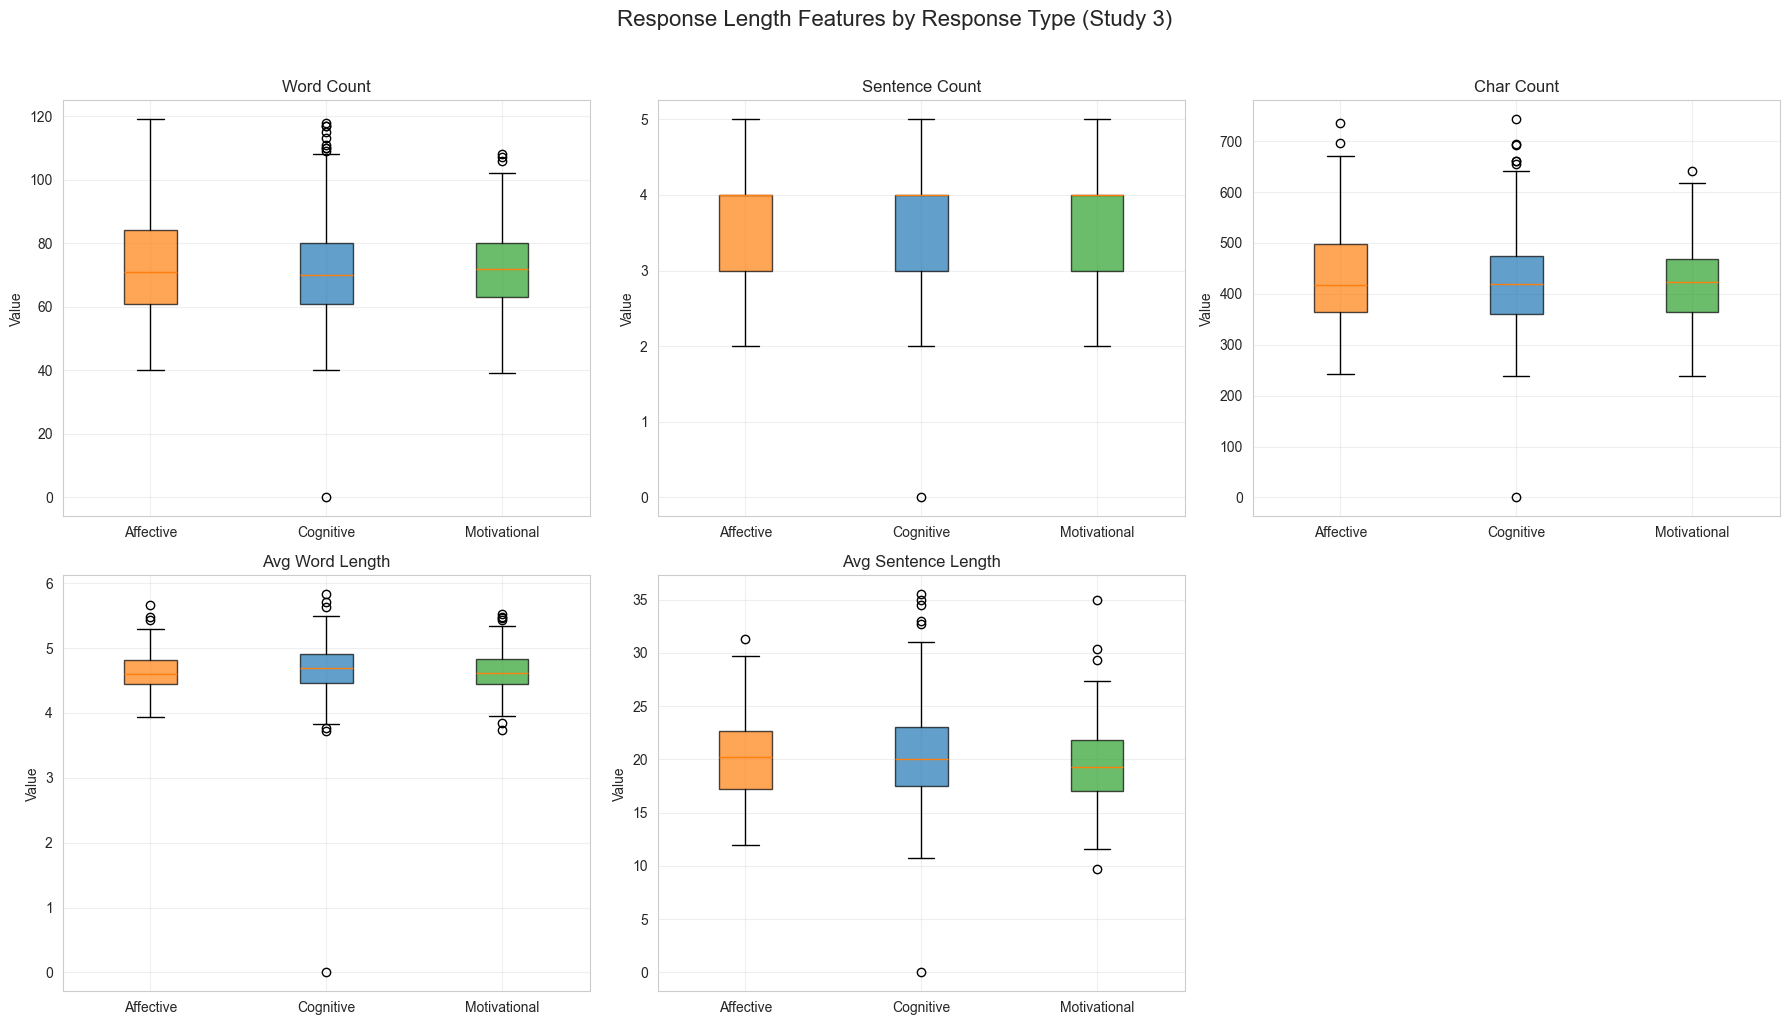

In [10]:
# Visualizations: Length by Response Type (Study 3)
if 'response_type_col' in locals() and response_type_col:
    study3_typed = study3_with_length[study3_with_length[response_type_col].notna()].copy()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    length_metrics = ['length_word_count', 'length_sentence_count', 'length_char_count', 
                      'length_avg_word_length', 'length_avg_sentence_length']
    
    for idx, metric in enumerate(length_metrics):
        ax = axes[idx]
        
        # Box plot
        data_to_plot = []
        labels = []
        colors_list = []
        for rt in sorted(study3_typed[response_type_col].unique()):
            group_data = study3_typed[study3_typed[response_type_col] == rt][metric].dropna()
            if len(group_data) > 0:
                data_to_plot.append(group_data.values)
                labels.append(rt)
                color = RESPONSE_COLORS.get(rt, '#808080')
                colors_list.append(color)
        
        if data_to_plot:
            bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            for patch, color in zip(bp['boxes'], colors_list):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            ax.set_title(metric.replace('length_', '').replace('_', ' ').title())
            ax.set_ylabel('Value')
            ax.grid(True, alpha=0.3)
    
    axes[5].axis('off')
    plt.suptitle('Response Length Features by Response Type (Study 3)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


**Visual Summary**: The box plots confirm the statistical findings. All three response types (Cognitive, Affective, Motivational) show remarkably similar distributions across all length features. Medians are nearly identical: ~70 words, ~3-4 sentences, ~400-410 characters, ~4.7 characters per word, and ~19 words per sentence. The interquartile ranges overlap substantially, indicating high similarity in response length characteristics. Notably, Cognitive responses show outliers at 0 across all features (likely empty/invalid responses that should be excluded). Upper outliers suggest some responses are substantially longer, but these are consistent across all response types. Overall, the visualizations support the conclusion that response types do not differ meaningfully in length, despite being designed to elicit different empathy styles.

### Section 4: Dominant Words Analysis

**Purpose**: Identify vocabulary signatures of each empathy style


In [11]:
# Preprocessing function for word extraction - FIXED VERSION
try:
    stop_words = set(stopwords.words('english'))
    print(f"Stopwords loaded: {len(stop_words)} words")
except:
    stop_words = set()
    print("Warning: Could not load stopwords, using empty set")

def get_words(text):
    """Extract words from text, removing stopwords and non-alphabetic tokens."""
    if pd.isna(text) or text == '' or str(text).strip() == '':
        return []
    
    text_str = str(text).strip()
    
    try:
        # Use NLTK tokenizer
        words = word_tokenize(text_str.lower())
        # Filter: keep only alphabetic words that aren't stopwords
        filtered_words = [w for w in words if w.isalpha() and w not in stop_words]
        return filtered_words
    except Exception as e:
        # Fallback: simple splitting
        words = text_str.lower().split()
        # Remove punctuation and filter
        import re
        words = [re.sub(r'[^\w\s]', '', w) for w in words]
        filtered_words = [w for w in words if w.isalpha() and len(w) > 0 and w not in stop_words]
        return filtered_words

# Test the function
test_text = "I can only begin to imagine the mixture of fear and concern you must have felt."
test_result = get_words(test_text)
print(f"Test: get_words() extracted {len(test_result)} words from test text")
print(f"Test: Sample words: {test_result[:10]}")
print("Word extraction function defined and tested.\n")

Stopwords loaded: 179 words
Test: get_words() extracted 7 words from test text
Test: Sample words: ['begin', 'imagine', 'mixture', 'fear', 'concern', 'must', 'felt']
Word extraction function defined and tested.



In [12]:
# Compute word frequencies for Study 3
from collections import Counter

study3_words = df[df['StudyNum'] == '3'].copy()

# Filter to responses with actual text
study3_words = study3_words[study3_words['Response'].notna()].copy()
study3_words = study3_words[study3_words['length_char_count'] > 0].copy()

print(f"Processing {len(study3_words)} responses with valid text...")

# Overall word frequencies
all_words = []
failed_count = 0

for idx, row in study3_words.iterrows():
    response_text = row.get('Response', '')
    if pd.isna(response_text) or str(response_text).strip() == '':
        continue
    
    words = get_words(response_text)
    if len(words) > 0:
        all_words.extend(words)
    else:
        failed_count += 1

if len(all_words) == 0:
    print("ERROR: No words extracted. Debugging...")
    if len(study3_words) > 0:
        sample = study3_words['Response'].iloc[0]
        print(f"Sample response: {str(sample)[:200]}...")
        # Debug step by step
        try:
            raw_words = word_tokenize(str(sample).lower())
            print(f"Step 1 - Raw tokenized: {len(raw_words)} words")
            alpha_words = [w for w in raw_words if w.isalpha()]
            print(f"Step 2 - Alphabetic only: {len(alpha_words)} words")
            non_stop = [w for w in alpha_words if w not in stop_words]
            print(f"Step 3 - After stopwords: {len(non_stop)} words")
            print(f"Sample words at each step:")
            print(f"  Raw: {raw_words[:10]}")
            print(f"  Alpha: {alpha_words[:10]}")
            print(f"  Final: {non_stop[:10]}")
        except Exception as e:
            print(f"Error: {e}")
else:
    overall_freq = Counter(all_words)
    print(f"Total unique words (Study 3): {len(overall_freq)}")
    print(f"Total word tokens: {len(all_words)}")
    if failed_count > 0:
        print(f"Note: {failed_count} responses failed to extract words")
    
    print(f"\nTop 20 words overall:")
    for word, count in overall_freq.most_common(20):
        print(f"  {word}: {count}")

Processing 1171 responses with valid text...
Total unique words (Study 3): 5006
Total word tokens: 42431

Top 20 words overall:
  youre: 672
  im: 622
  must: 578
  feel: 554
  feeling: 416
  sorry: 413
  remember: 400
  hear: 383
  truly: 374
  time: 370
  really: 314
  like: 298
  deeply: 255
  feelings: 247
  sense: 246
  love: 246
  joy: 236
  especially: 231
  emotions: 220
  youve: 214


**key takeway**: intersting to see they use a lot of language that emphasizes agancy of both sizes. it is not only about "you" (the human telling the story) but also about "me" (the AI agent). 

In [13]:
# Word frequencies by response type
if 'response_type_col' in locals() and response_type_col and response_type_col in study3_words.columns:
    study3_typed_words = study3_words[study3_words[response_type_col].notna()].copy()
    
    response_type_freqs = {}
    for rt in study3_typed_words[response_type_col].unique():
        words_list = []
        for idx, row in study3_typed_words[study3_typed_words[response_type_col] == rt].iterrows():
            words = get_words(row.get('Response', ''))
            words_list.extend(words)
        response_type_freqs[rt] = Counter(words_list)
    
    print("\n" + "="*80)
    print("TOP 10 WORDS BY RESPONSE TYPE")
    print("="*80)
    
    top_n = 10
    for rt in sorted(response_type_freqs.keys()):
        print(f"\n{rt}:")
        for word, count in response_type_freqs[rt].most_common(top_n):
            print(f"  {word}: {count}")
else:
    print("Response type column not available for word frequency analysis.")



TOP 10 WORDS BY RESPONSE TYPE

Affective:
  im: 73
  youre: 70
  feel: 68
  must: 67
  truly: 55
  sorry: 47
  remember: 47
  hear: 41
  time: 41
  deeply: 39

Cognitive:
  youre: 485
  must: 443
  im: 428
  feel: 404
  feeling: 315
  sorry: 286
  hear: 269
  time: 268
  remember: 265
  truly: 263

Motivational:
  im: 121
  youre: 117
  remember: 88
  feel: 82
  sorry: 80
  hear: 73
  must: 68
  feeling: 64
  time: 61
  really: 57


**takeway** : following the last point, it seems motivational and affective (which some researchers consider the same kind) is even more about "me".

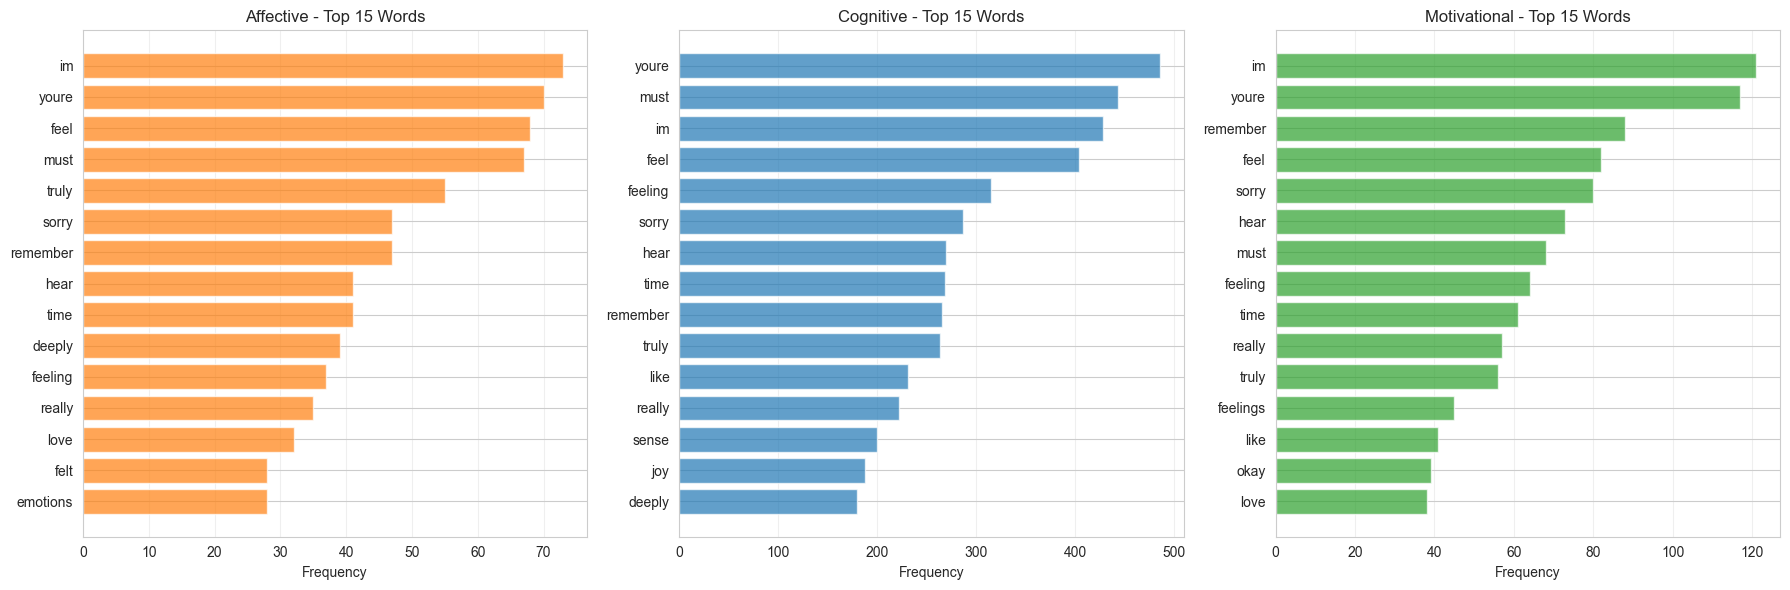

In [14]:
# Visualizations: Word frequencies
if 'response_type_freqs' in locals() and response_type_freqs:
    fig, axes = plt.subplots(1, len(response_type_freqs), figsize=(6*len(response_type_freqs), 6))
    if len(response_type_freqs) == 1:
        axes = [axes]
    
    for idx, (rt, freq_dict) in enumerate(sorted(response_type_freqs.items())):
        top_words = [word for word, _ in freq_dict.most_common(15)]
        top_counts = [count for _, count in freq_dict.most_common(15)]
        
        color = RESPONSE_COLORS.get(rt, '#808080')
        axes[idx].barh(range(len(top_words)), top_counts, color=color, alpha=0.7)
        axes[idx].set_yticks(range(len(top_words)))
        axes[idx].set_yticklabels(top_words)
        axes[idx].invert_yaxis()
        axes[idx].set_xlabel('Frequency')
        axes[idx].set_title(f'{rt} - Top 15 Words')
        axes[idx].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()


**Key Takeaway**: The vocabulary analysis reveals high similarity across response types. The top words are generic empathy language ("you're", "I'm", "must", "feel", "sorry", "remember") that appear across all three types. Cognitive responses show higher absolute frequencies (e.g., "you're": 485 vs 70-117), but this reflects their larger sample size (n=860 vs 132-180) rather than distinctive vocabulary. The word lists are nearly identical across types, with only minor ordering differences. This suggests that despite being designed to elicit different empathy styles, the responses share a common linguistic core, with limited vocabulary differentiation between cognitive, affective, and motivational approaches.


Installing wordcloud library...


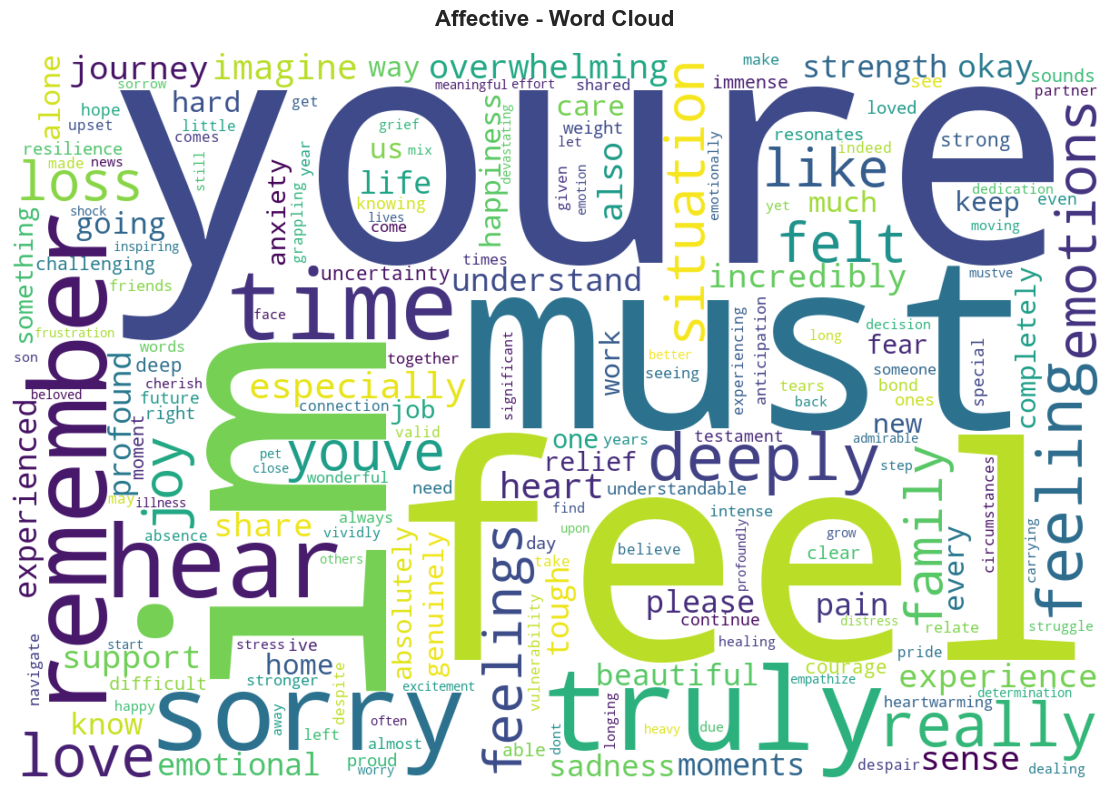

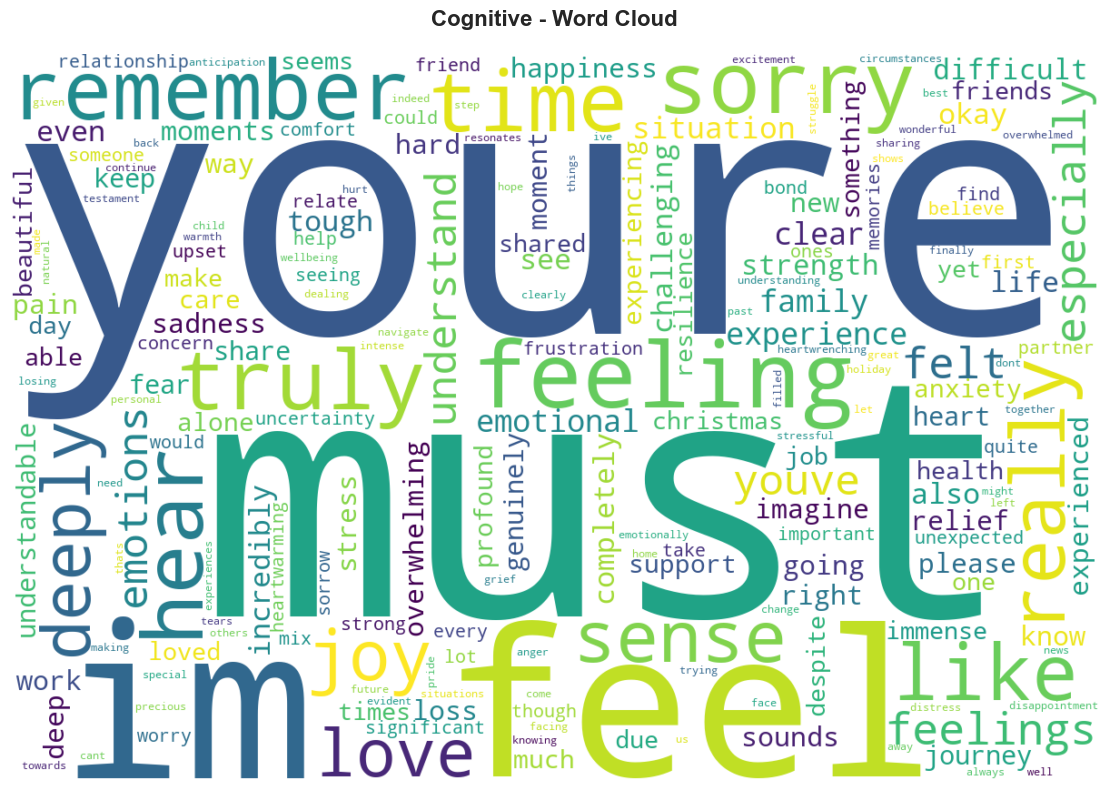

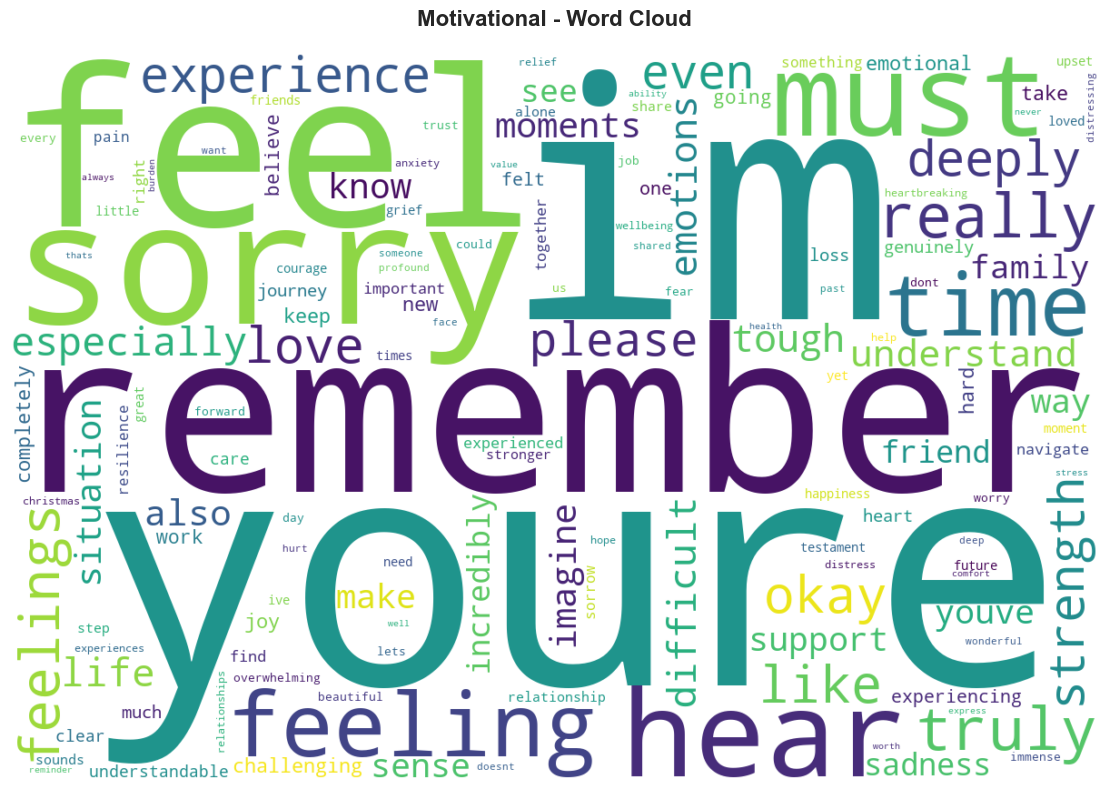

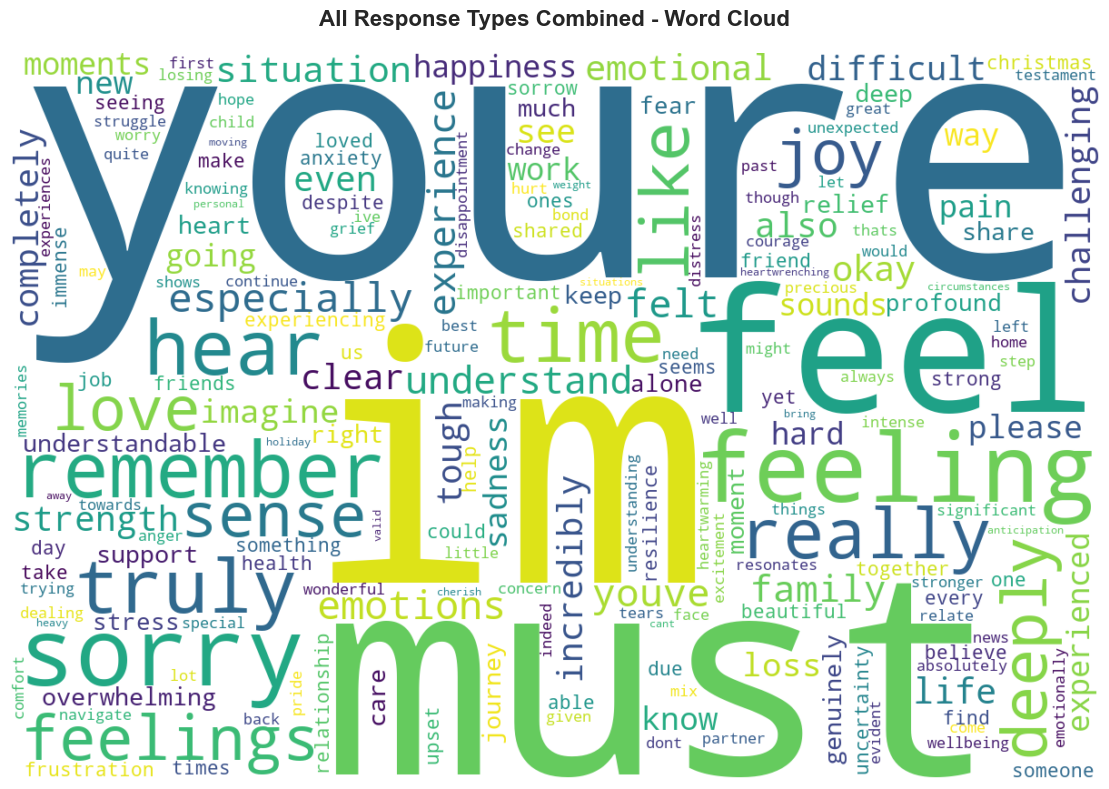


WORD CLOUD SUMMARY
Total unique words across all response types: 5006
Affective: 1669 unique words
Cognitive: 4354 unique words
Motivational: 1900 unique words


In [41]:
# Word cloud visualization: All words by frequency
from collections import Counter
try:
    from wordcloud import WordCloud
except ImportError:
    print("Installing wordcloud library...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'wordcloud', '-q'])
    from wordcloud import WordCloud

if 'response_type_freqs' in locals() and response_type_freqs:
    # Calculate total frequencies across all response types
    all_words_counter = Counter()
    for freq_dict in response_type_freqs.values():
        all_words_counter.update(freq_dict)
    
    # Create word cloud for each response type
    for rt, freq_dict in sorted(response_type_freqs.items()):
        # Convert Counter to dictionary for WordCloud
        word_freq_dict = dict(freq_dict)
        
        # Get color for this response type
        color = RESPONSE_COLORS.get(rt, '#808080')
        
        # Create word cloud
        wordcloud = WordCloud(
            width=1200, 
            height=800,
            background_color='white',
            colormap='viridis',
            max_words=200,
            relative_scaling=0.5,
            min_font_size=10
        ).generate_from_frequencies(word_freq_dict)
        
        # Plot
        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'{rt} - Word Cloud', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    
    # Create word cloud for all words together
    all_word_freq_dict = dict(all_words_counter)
    
    wordcloud_all = WordCloud(
        width=1200, 
        height=800,
        background_color='white',
        colormap='viridis',
        max_words=200,
        relative_scaling=0.5,
        min_font_size=10
    ).generate_from_frequencies(all_word_freq_dict)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud_all, interpolation='bilinear')
    plt.axis('off')
    plt.title('All Response Types Combined - Word Cloud', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("WORD CLOUD SUMMARY")
    print("="*80)
    print(f"Total unique words across all response types: {len(all_words_counter)}")
    for rt in sorted(response_type_freqs.keys()):
        print(f"{rt}: {len(response_type_freqs[rt])} unique words")
else:
    print("response_type_freqs not available for word cloud visualization.")


### Section 5: Word Dominance Concentration

**Purpose**: Measure how formulaic/repetitive the language is


In [16]:
# Helper functions for dominance metrics
def top_n_coverage(word_freq, n):
    """What % of total word tokens do top N words account for?"""
    sorted_freq = sorted(word_freq.values(), reverse=True)
    total = sum(word_freq.values())
    return sum(sorted_freq[:n]) / total if total > 0 else 0

def gini_coefficient(x):
    """Compute Gini coefficient of word frequencies."""
    x = np.sort(x)
    n = len(x)
    if n == 0 or np.sum(x) == 0:
        return 0
    return (2 * np.sum((np.arange(1, n+1) * x))) / (n * np.sum(x)) - (n + 1) / n

print("Dominance metric functions defined.")


Dominance metric functions defined.


In [17]:
# Compute dominance metrics per response
print("Computing word dominance metrics for each response...")
dominance_metrics = []

for idx, row in df.iterrows():
    words = get_words(row.get('Response', ''))
    if len(words) == 0:
        dominance_metrics.append({
            'top_10_coverage': 0,
            'top_20_coverage': 0,
            'top_50_coverage': 0,
            'gini_coefficient': 0
        })
        continue
    
    word_freq = Counter(words)
    
    top_10 = top_n_coverage(word_freq, 10)
    top_20 = top_n_coverage(word_freq, 20)
    top_50 = top_n_coverage(word_freq, 50)
    gini = gini_coefficient(list(word_freq.values()))
    
    dominance_metrics.append({
        'top_10_coverage': top_10,
        'top_20_coverage': top_20,
        'top_50_coverage': top_50,
        'gini_coefficient': gini
    })

dominance_df = pd.DataFrame(dominance_metrics)
for col in dominance_df.columns:
    df[f'dominance_{col}'] = dominance_df[col]

print(f"Dominance metrics computed for {len(df)} responses.")


Computing word dominance metrics for each response...
Dominance metrics computed for 2490 responses.


In [18]:
# Compare dominance metrics by response type (Study 3)
if 'response_type_col' in locals() and response_type_col and response_type_col in df.columns:
    study3_dom = df[(df['StudyNum'] == '3') & (df[response_type_col].notna())].copy()
    
    dominance_vars = ['dominance_top_10_coverage', 'dominance_top_20_coverage', 
                      'dominance_top_50_coverage', 'dominance_gini_coefficient']
    
    print("="*80)
    print("WORD DOMINANCE METRICS BY RESPONSE TYPE (Study 3)")
    print("="*80)
    
    for var in dominance_vars:
        print(f"\n{var.replace('dominance_', '').replace('_', ' ').title()}:")
        
        groups = []
        group_names = []
        for rt in study3_dom[response_type_col].unique():
            group_data = study3_dom[study3_dom[response_type_col] == rt][var].dropna()
            if len(group_data) > 0:
                groups.append(group_data)
                group_names.append(rt)
        
        if len(groups) >= 2:
            for name, group in zip(group_names, groups):
                print(f"  {name}: M={group.mean():.3f}, SD={group.std():.3f}")
            
            from scipy.stats import kruskal
            h_stat, p_value = kruskal(*groups)
            print(f"  Kruskal-Wallis: H = {h_stat:.3f}, p = {p_value:.4f}")


WORD DOMINANCE METRICS BY RESPONSE TYPE (Study 3)

Top 10 Coverage:
  Cognitive: M=0.331, SD=0.061
  Motivational: M=0.331, SD=0.066
  Affective: M=0.324, SD=0.062
  Kruskal-Wallis: H = 3.202, p = 0.2017

Top 20 Coverage:
  Cognitive: M=0.619, SD=0.113
  Motivational: M=0.617, SD=0.122
  Affective: M=0.606, SD=0.120
  Kruskal-Wallis: H = 2.725, p = 0.2560

Top 50 Coverage:
  Cognitive: M=0.998, SD=0.035
  Motivational: M=1.000, SD=0.005
  Affective: M=0.996, SD=0.020
  Kruskal-Wallis: H = 4.431, p = 0.1091

Gini Coefficient:
  Cognitive: M=0.040, SD=0.031
  Motivational: M=0.041, SD=0.030
  Affective: M=0.039, SD=0.033
  Kruskal-Wallis: H = 0.830, p = 0.6602


**Key Takeaway**: 

**Technical Explanation**: Word dominance metrics measure vocabulary concentration. **Top-N Coverage** calculates what percentage of all word tokens in a response are accounted for by the N most frequent words (e.g., if top 10 words appear 33 times out of 100 total words, coverage = 0.33). Higher coverage indicates more repetitive, formulaic language. **Gini Coefficient** measures inequality in word frequency distribution within each response, ranging from 0 (all words appear equally often) to 1 (one word dominates completely). Lower Gini indicates more balanced word usage within a response.

**Interpretation**: All response types show high formulaicity with no significant differences (all p > 0.10). Top 50 words account for ~99-100% of vocabulary, indicating responses rely on a small core vocabulary. Top 10 words cover ~33% of tokens, and top 20 cover ~60-62%, showing strong concentration. The low Gini coefficients (~0.04) indicate relatively balanced word frequencies within individual responses, but the high top-N coverage reveals the same words recur across responses. This suggests AI-generated responses follow similar linguistic templates regardless of empathy type, with limited vocabulary diversity. The lack of significant differences indicates that cognitive, affective, and motivational prompts did not produce meaningfully different levels of formulaicity.

### Section 6: Lexical Diversity

**Purpose**: Measure vocabulary richness


In [19]:
# Compute lexical diversity metrics
print("Computing lexical diversity metrics...")
diversity_metrics = []

for idx, row in df.iterrows():
    words = get_words(row.get('Response', ''))
    if len(words) == 0:
        diversity_metrics.append({
            'ttr': 0,  # Type-Token Ratio
            'rttr': 0,  # Root TTR (Guiraud's index)
            'hapax_ratio': 0  # Hapax legomena ratio
        })
        continue
    
    unique_words = set(words)
    word_freq = Counter(words)
    
    # Type-Token Ratio
    ttr = len(unique_words) / len(words) if len(words) > 0 else 0
    
    # Root TTR (Guiraud's index)
    rttr = len(unique_words) / np.sqrt(len(words)) if len(words) > 0 else 0
    
    # Hapax legomena ratio (words that appear only once)
    hapax_count = sum(1 for count in word_freq.values() if count == 1)
    hapax_ratio = hapax_count / len(words) if len(words) > 0 else 0
    
    diversity_metrics.append({
        'ttr': ttr,
        'rttr': rttr,
        'hapax_ratio': hapax_ratio
    })

diversity_df = pd.DataFrame(diversity_metrics)
for col in diversity_df.columns:
    df[f'diversity_{col}'] = diversity_df[col]

print(f"Lexical diversity metrics computed for {len(df)} responses.")


Computing lexical diversity metrics...
Lexical diversity metrics computed for 2490 responses.


In [20]:
# Compare diversity by response type (Study 3)
if 'response_type_col' in locals() and response_type_col and response_type_col in df.columns:
    study3_div = df[(df['StudyNum'] == '3') & (df[response_type_col].notna())].copy()
    
    diversity_vars = ['diversity_ttr', 'diversity_rttr', 'diversity_hapax_ratio']
    
    print("="*80)
    print("LEXICAL DIVERSITY BY RESPONSE TYPE (Study 3)")
    print("="*80)
    
    for var in diversity_vars:
        print(f"\n{var.replace('diversity_', '').upper()}:")
        
        groups = []
        group_names = []
        for rt in study3_div[response_type_col].unique():
            group_data = study3_div[study3_div[response_type_col] == rt][var].dropna()
            if len(group_data) > 0:
                groups.append(group_data)
                group_names.append(rt)
        
        if len(groups) >= 2:
            for name, group in zip(group_names, groups):
                print(f"  {name}: M={group.mean():.3f}, SD={group.std():.3f}")
            
            f_stat, p_value = f_oneway(*groups)
            all_data = study3_div[var].dropna()
            ss_total = np.sum((all_data - all_data.mean())**2)
            ss_between = sum(len(g) * (g.mean() - all_data.mean())**2 for g in groups)
            eta_sq = eta_squared(ss_between, ss_total)
            print(f"  ANOVA: F({len(groups)-1}, {len(all_data)-len(groups)}) = {f_stat:.3f}, p = {p_value:.4f}, η² = {eta_sq:.3f}")


LEXICAL DIVERSITY BY RESPONSE TYPE (Study 3)

TTR:
  Cognitive: M=0.956, SD=0.048
  Motivational: M=0.956, SD=0.034
  Affective: M=0.959, SD=0.036
  ANOVA: F(2, 1169) = 0.269, p = 0.7643, η² = 0.000

RTTR:
  Cognitive: M=5.706, SD=0.586
  Motivational: M=5.733, SD=0.581
  Affective: M=5.805, SD=0.619
  ANOVA: F(2, 1169) = 1.677, p = 0.1873, η² = 0.003

HAPAX_RATIO:
  Cognitive: M=0.915, SD=0.073
  Motivational: M=0.914, SD=0.064
  Affective: M=0.921, SD=0.067
  ANOVA: F(2, 1169) = 0.480, p = 0.6186, η² = 0.001


**Key Takeaway**: 

**Technical Explanation**: Lexical diversity metrics measure vocabulary richness. **TTR (Type-Token Ratio)** = unique words / total words, ranging from 0 to 1. Higher values indicate more diverse vocabulary (more unique words relative to total). **RTTR (Root TTR / Guiraud's index)** = unique words / √(total words), which adjusts for text length bias. Higher values indicate richer vocabulary independent of length. **Hapax Ratio** = proportion of words that appear only once in a response. Higher values indicate more unique, non-repeated vocabulary.

**Interpretation**: All response types show extremely high lexical diversity with no significant differences (all p > 0.18). TTR values (~0.96) indicate that ~96% of words in each response are unique—nearly every word appears only once. Hapax ratios (~0.91-0.92) confirm that 91-92% of words appear exactly once. This high within-response diversity contrasts with the earlier finding of high formulaicity across responses (top 50 words dominate overall vocabulary). Together, these suggest that while responses share a common core vocabulary across the dataset, each individual response uses that vocabulary with minimal repetition, creating diverse word combinations within responses but similar word choices across responses. The lack of significant differences indicates that empathy type does not affect vocabulary richness.

### Section 7: Style Mimicry Analysis

**Purpose**: Does the AI adapt its style to the participant's story?


In [21]:
# Compute mimicry features
print("Computing style mimicry features...")
mimicry_metrics = []

for idx, row in df.iterrows():
    story = row.get('Story', '')
    response = row.get('Response', '')
    
    story_words = get_words(story)
    response_words = get_words(response)
    
    if len(story_words) == 0 or len(response_words) == 0:
        mimicry_metrics.append({
            'length_ratio': np.nan,
            'jaccard_similarity': np.nan,
            'shared_content_words': 0,
            'sentence_length_diff': np.nan
        })
        continue
    
    # Length ratio
    length_ratio = len(response_words) / len(story_words) if len(story_words) > 0 else np.nan
    
    # Jaccard similarity (vocabulary overlap)
    story_set = set(story_words)
    response_set = set(response_words)
    intersection = len(story_set & response_set)
    union = len(story_set | response_set)
    jaccard = intersection / union if union > 0 else 0
    
    # Shared content words count
    shared_content_words = intersection
    
    # Sentence length difference
    try:
        story_sents = sent_tokenize(str(story))
        response_sents = sent_tokenize(str(response))
        story_avg_sent_len = len(story_words) / max(len(story_sents), 1) if story_sents else 0
        response_avg_sent_len = len(response_words) / max(len(response_sents), 1) if response_sents else 0
        sentence_length_diff = abs(story_avg_sent_len - response_avg_sent_len) if (story_avg_sent_len > 0 and response_avg_sent_len > 0) else np.nan
    except:
        sentence_length_diff = np.nan
    
    mimicry_metrics.append({
        'length_ratio': length_ratio,
        'jaccard_similarity': jaccard,
        'shared_content_words': shared_content_words,
        'sentence_length_diff': sentence_length_diff
    })

mimicry_df = pd.DataFrame(mimicry_metrics)
for col in mimicry_df.columns:
    df[f'mimicry_{col}'] = mimicry_df[col]

print(f"Mimicry metrics computed for {len(df)} responses.")
print(f"Valid mimicry pairs (both story and response have words): {(df['mimicry_jaccard_similarity'].notna()).sum()}")


Computing style mimicry features...
Mimicry metrics computed for 2490 responses.
Valid mimicry pairs (both story and response have words): 2488


In [22]:
# Compare mimicry by response type (Study 3)
if 'response_type_col' in locals() and response_type_col and response_type_col in df.columns:
    study3_mim = df[(df['StudyNum'] == '3') & (df[response_type_col].notna())].copy()
    study3_mim = study3_mim[study3_mim['mimicry_jaccard_similarity'].notna()].copy()
    
    mimicry_vars = ['mimicry_length_ratio', 'mimicry_jaccard_similarity', 
                    'mimicry_shared_content_words', 'mimicry_sentence_length_diff']
    
    print("="*80)
    print("STYLE MIMICRY BY RESPONSE TYPE (Study 3)")
    print("="*80)
    
    for var in mimicry_vars:
        print(f"\n{var.replace('mimicry_', '').replace('_', ' ').title()}:")
        
        groups = []
        group_names = []
        for rt in study3_mim[response_type_col].unique():
            group_data = study3_mim[study3_mim[response_type_col] == rt][var].dropna()
            if len(group_data) > 0:
                groups.append(group_data)
                group_names.append(rt)
        
        if len(groups) >= 2:
            for name, group in zip(group_names, groups):
                print(f"  {name}: M={group.mean():.3f}, SD={group.std():.3f}, N={len(group)}")
            
            f_stat, p_value = f_oneway(*groups)
            all_data = study3_mim[var].dropna()
            ss_total = np.sum((all_data - all_data.mean())**2)
            ss_between = sum(len(g) * (g.mean() - all_data.mean())**2 for g in groups)
            eta_sq = eta_squared(ss_between, ss_total)
            print(f"  ANOVA: F({len(groups)-1}, {len(all_data)-len(groups)}) = {f_stat:.3f}, p = {p_value:.4f}, η² = {eta_sq:.3f}")
            
            # Post-hoc if significant
            if len(groups) == 3 and p_value < 0.05:
                from itertools import combinations
                comparisons = list(combinations(range(len(groups)), 2))
                n_comparisons = len(comparisons)
                bonferroni_alpha = 0.05 / n_comparisons
                
                print(f"  Post-hoc pairwise comparisons (Bonferroni α = {bonferroni_alpha:.4f}):")
                for i, j in comparisons:
                    t_stat, p_val = ttest_ind(groups[i], groups[j], equal_var=False)
                    d = cohens_d(groups[i], groups[j])
                    sig = '*' if p_val < bonferroni_alpha else ''
                    print(f"    {group_names[i]} vs {group_names[j]}: t = {t_stat:.3f}, p = {p_val:.4f}{sig}, d = {d:.3f}")


STYLE MIMICRY BY RESPONSE TYPE (Study 3)

Length Ratio:
  Cognitive: M=7.145, SD=8.258, N=859
  Motivational: M=7.457, SD=8.146, N=180
  Affective: M=6.646, SD=8.560, N=132
  ANOVA: F(2, 1168) = 0.367, p = 0.6928, η² = 0.001

Jaccard Similarity:
  Cognitive: M=0.060, SD=0.058, N=859
  Motivational: M=0.051, SD=0.054, N=180
  Affective: M=0.061, SD=0.059, N=132
  ANOVA: F(2, 1168) = 1.980, p = 0.1385, η² = 0.003

Shared Content Words:
  Cognitive: M=3.432, SD=3.576, N=859
  Motivational: M=2.906, SD=3.220, N=180
  Affective: M=3.424, SD=3.191, N=132
  ANOVA: F(2, 1168) = 1.734, p = 0.1771, η² = 0.003

Sentence Length Diff:


**Key Takeaway**: 

**Technical Explanation**: Style mimicry metrics measure how much AI responses adapt to participant stories. **Length Ratio** = response word count / story word count (values > 1 indicate longer responses). **Jaccard Similarity** = shared vocabulary / total unique vocabulary (0-1 scale, higher = more overlap). **Shared Content Words** = count of words appearing in both story and response. **Sentence Length Diff** = absolute difference in average sentence length between story and response.

**Interpretation**: All response types show minimal style mimicry with no significant differences (all p > 0.13, η² < 0.003). Jaccard similarity is very low (~0.05-0.06), indicating responses share only 5-6% of vocabulary with stories. Responses average 2.9-3.4 shared content words with stories, and are ~7x longer than stories on average. This suggests the AI does not meaningfully adapt its vocabulary or style to match participant stories, regardless of empathy type. The lack of significant differences indicates that cognitive, affective, and motivational prompts do not produce different levels of style mimicry—all show similarly low adaptation to story content.

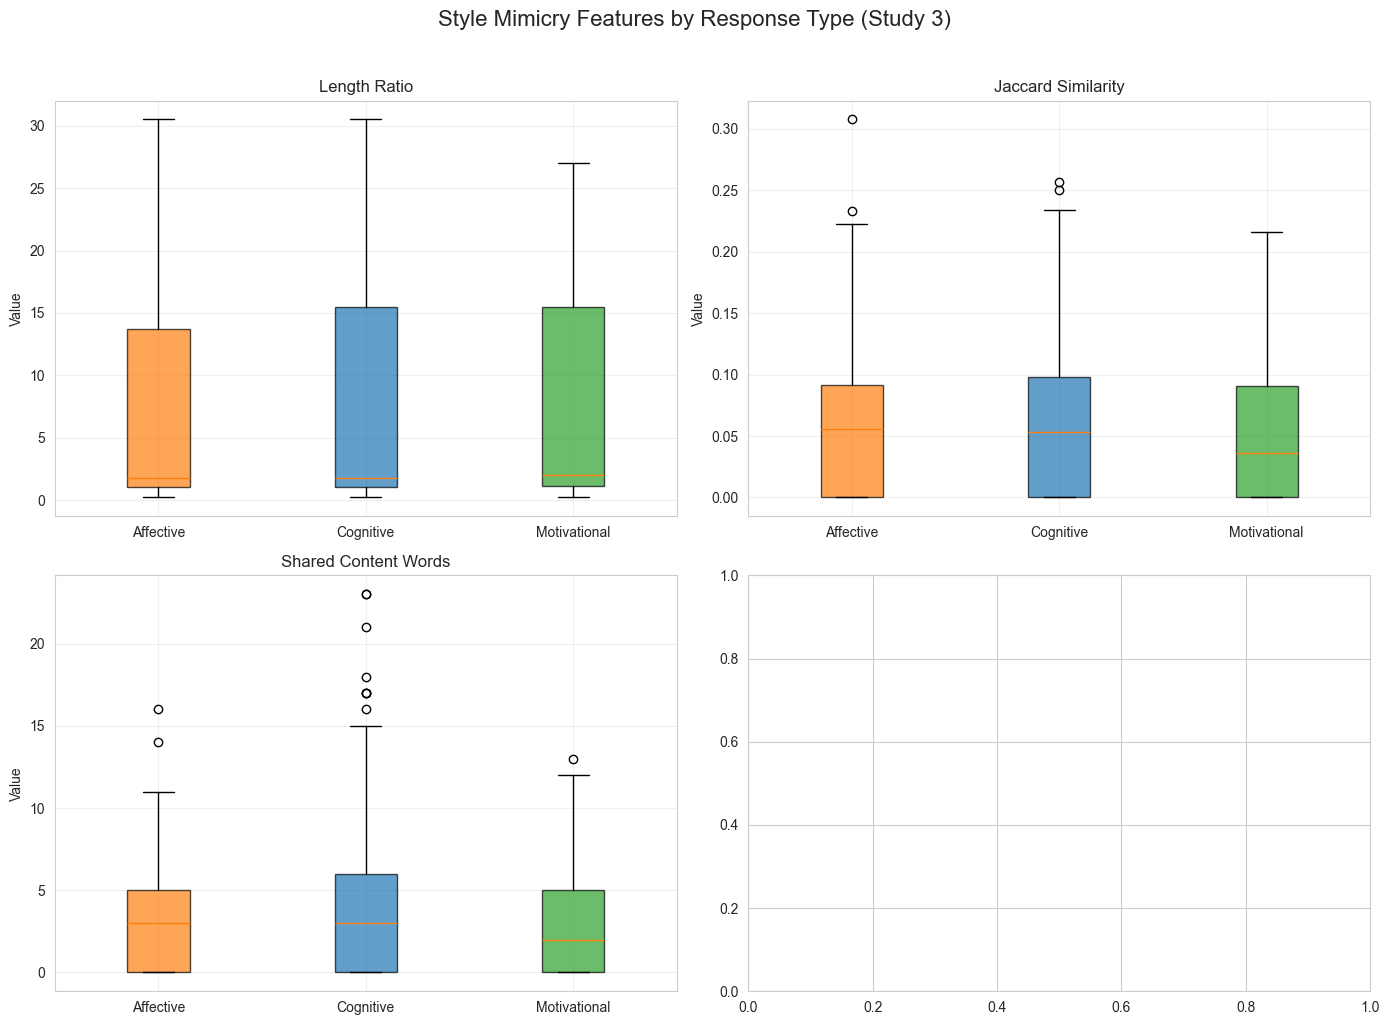

In [23]:
# Visualizations: Mimicry features
if 'response_type_col' in locals() and response_type_col and response_type_col in df.columns:
    study3_mim = df[(df['StudyNum'] == '3') & (df[response_type_col].notna())].copy()
    study3_mim = study3_mim[study3_mim['mimicry_jaccard_similarity'].notna()].copy()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    mimicry_vars = ['mimicry_length_ratio', 'mimicry_jaccard_similarity', 
                    'mimicry_shared_content_words', 'mimicry_sentence_length_diff']
    
    for idx, var in enumerate(mimicry_vars):
        ax = axes[idx]
        
        data_to_plot = []
        labels = []
        colors_list = []
        for rt in sorted(study3_mim[response_type_col].unique()):
            group_data = study3_mim[study3_mim[response_type_col] == rt][var].dropna()
            if len(group_data) > 0:
                data_to_plot.append(group_data.values)
                labels.append(rt)
                color = RESPONSE_COLORS.get(rt, '#808080')
                colors_list.append(color)
        
        if data_to_plot:
            bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            for patch, color in zip(bp['boxes'], colors_list):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            ax.set_title(var.replace('mimicry_', '').replace('_', ' ').title())
            ax.set_ylabel('Value')
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Style Mimicry Features by Response Type (Study 3)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


**Visual Summary**: The box plots confirm the statistical findings of minimal style mimicry across all response types. Length ratios show very similar distributions with low medians (~1.5) but wide ranges extending up to 30, indicating substantial variability in how much longer responses are compared to stories. Jaccard similarity distributions are nearly identical across types, with low medians (~0.03-0.05) and a few outliers, confirming minimal vocabulary overlap. Shared content words show slight variation (Cognitive median ~3 vs. Affective/Motivational ~1-2), but all distributions are right-skewed with most responses sharing very few words with stories. Overall, the visualizations reinforce that AI responses do not meaningfully adapt their vocabulary or style to match participant stories, regardless of empathy type, with high variability but consistently low mimicry across all measures.

In [24]:
# Correlation between mimicry and outcomes (Study 3)
if 'response_type_col' in locals() and response_type_col and response_type_col in df.columns:
    study3_corr = df[(df['StudyNum'] == '3') & (df[response_type_col].notna())].copy()
    study3_corr = study3_corr[study3_corr['mimicry_jaccard_similarity'].notna()].copy()
    
    outcome_vars = ['EmpathyQ_1', 'cognitive', 'affective', 'motivational', 'PosRes']
    outcome_vars = [v for v in outcome_vars if v in study3_corr.columns]
    
    mimicry_vars = ['mimicry_length_ratio', 'mimicry_jaccard_similarity', 
                    'mimicry_shared_content_words', 'mimicry_sentence_length_diff']
    
    print("="*80)
    print("CORRELATIONS: MIMICRY FEATURES vs OUTCOME VARIABLES (Study 3)")
    print("="*80)
    
    corr_results = []
    for outcome in outcome_vars:
        for mimicry in mimicry_vars:
            valid_data = study3_corr[[outcome, mimicry]].dropna()
            if len(valid_data) >= 3:
                r_pearson, p_pearson = pearsonr(valid_data[outcome], valid_data[mimicry])
                r_spearman, p_spearman = spearmanr(valid_data[outcome], valid_data[mimicry])
                
                corr_results.append({
                    'outcome': outcome,
                    'mimicry_feature': mimicry.replace('mimicry_', ''),
                    'pearson_r': r_pearson,
                    'pearson_p': p_pearson,
                    'spearman_r': r_spearman,
                    'spearman_p': p_spearman
                })
    
    corr_df = pd.DataFrame(corr_results)
    
    # Display by outcome
    for outcome in outcome_vars:
        subset = corr_df[corr_df['outcome'] == outcome].copy()
        if len(subset) > 0:
            subset = subset.sort_values('spearman_r', key=abs, ascending=False)
            print(f"\n{outcome}:")
            print(f"{'Mimicry Feature':<30} {'Spearman r':<12} {'p-value':<12} {'Pearson r':<12} {'p-value':<12}")
            print("-" * 80)
            for _, row in subset.iterrows():
                sig_s = '*' if row['spearman_p'] < 0.05 else ''
                sig_p = '*' if row['pearson_p'] < 0.05 else ''
                print(f"{row['mimicry_feature']:<30} {row['spearman_r']:>10.3f}{sig_s:<2} {row['spearman_p']:>10.4f} {row['pearson_r']:>10.3f}{sig_p:<2} {row['pearson_p']:>10.4f}")


CORRELATIONS: MIMICRY FEATURES vs OUTCOME VARIABLES (Study 3)

EmpathyQ_1:
Mimicry Feature                Spearman r   p-value      Pearson r    p-value     
--------------------------------------------------------------------------------
shared_content_words                0.037       0.2100      0.024       0.4194
length_ratio                       -0.031       0.2965     -0.033       0.2631
jaccard_similarity                  0.025       0.3968      0.007       0.8241

cognitive:
Mimicry Feature                Spearman r   p-value      Pearson r    p-value     
--------------------------------------------------------------------------------
shared_content_words                0.064*      0.0281      0.037       0.2085
length_ratio                       -0.057       0.0521     -0.043       0.1368
jaccard_similarity                  0.047       0.1050      0.010       0.7287

affective:
Mimicry Feature                Spearman r   p-value      Pearson r    p-value     
----------------

**Key Takeaway**: Style mimicry features show minimal relationships with empathy ratings, but this may reflect limited variation in mimicry rather than a true absence of effect. Only 3 of 20 correlations are significant (p < 0.05), with very small effect sizes (|r| < 0.07). **Shared content words** shows weak positive correlations with cognitive (r = 0.064, p = 0.028) and affective (r = 0.065, p = 0.027) empathy, and **length ratio** shows a weak negative correlation with affective empathy (r = -0.059, p = 0.044). However, given that mimicry is consistently very low across all responses (Jaccard similarity ~0.05, shared words ~2-3), there is limited range to detect meaningful relationships—a floor effect. The weak but consistent pattern (more shared words → slightly higher cognitive/affective ratings; longer responses relative to stories → slightly lower affective ratings) suggests there may be a small effect of mimicry on empathy ratings, but it cannot be meaningfully evaluated when mimicry itself is so minimal. The lack of substantial style adaptation in the responses constrains our ability to assess whether greater mimicry would enhance perceived empathy.

## PART II: Rating/Outcome Analysis

### Section 8: Outcome Variable Distributions

**Purpose**: Understand rating distributions before modeling


In [25]:
# Identify outcome variables
outcome_vars = []
potential_vars = ['EmpathyQ_1', 'cognitive', 'affective', 'motivational', 
                  'PosRes', 'Support', 'Authenticity_1']

for var in potential_vars:
    if var in df.columns:
        outcome_vars.append(var)

print(f"Outcome variables found: {outcome_vars}")

# Descriptive statistics
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS FOR OUTCOME VARIABLES")
print("="*80)

for var in outcome_vars:
    data = df[var].dropna()
    if len(data) > 0:
        print(f"\n{var}:")
        print(f"  Mean: {data.mean():.2f}")
        print(f"  SD: {data.std():.2f}")
        print(f"  Median: {data.median():.2f}")
        print(f"  Min: {data.min():.2f}")
        print(f"  Max: {data.max():.2f}")
        print(f"  Range: {data.max() - data.min():.2f}")
        
        # Ceiling/floor effects
        if data.max() > 0:
            pct_max = (data == data.max()).sum() / len(data) * 100
            pct_min = (data == data.min()).sum() / len(data) * 100
            print(f"  Ceiling effect (% at max): {pct_max:.1f}%")
            print(f"  Floor effect (% at min): {pct_min:.1f}%")
        
        # Normality test (Shapiro-Wilk) - only for smaller samples
        if len(data) <= 5000:
            from scipy.stats import shapiro
            stat, p_val = shapiro(data)
            print(f"  Shapiro-Wilk: W = {stat:.3f}, p = {p_val:.4f}")


Outcome variables found: ['EmpathyQ_1', 'cognitive', 'affective', 'motivational', 'PosRes', 'Authenticity_1']

DESCRIPTIVE STATISTICS FOR OUTCOME VARIABLES

EmpathyQ_1:
  Mean: 7.77
  SD: 1.72
  Median: 8.00
  Min: 0.00
  Max: 9.00
  Range: 9.00
  Ceiling effect (% at max): 47.9%
  Floor effect (% at min): 0.9%
  Shapiro-Wilk: W = 0.731, p = 0.0000

cognitive:
  Mean: 7.58
  SD: 1.65
  Median: 8.00
  Min: 0.25
  Max: 9.40
  Range: 9.15
  Ceiling effect (% at max): 4.3%
  Floor effect (% at min): 0.3%
  Shapiro-Wilk: W = 0.875, p = 0.0000

affective:
  Mean: 6.75
  SD: 1.95
  Median: 7.00
  Min: 0.25
  Max: 9.40
  Range: 9.15
  Ceiling effect (% at max): 2.5%
  Floor effect (% at min): 0.3%
  Shapiro-Wilk: W = 0.938, p = 0.0000

motivational:
  Mean: 7.05
  SD: 1.70
  Median: 7.25
  Min: 0.25
  Max: 9.40
  Range: 9.15
  Ceiling effect (% at max): 2.8%
  Floor effect (% at min): 0.2%
  Shapiro-Wilk: W = 0.940, p = 0.0000

PosRes:
  Mean: 68.43
  SD: 24.71
  Median: 73.33
  Min: 0.00
  Ma

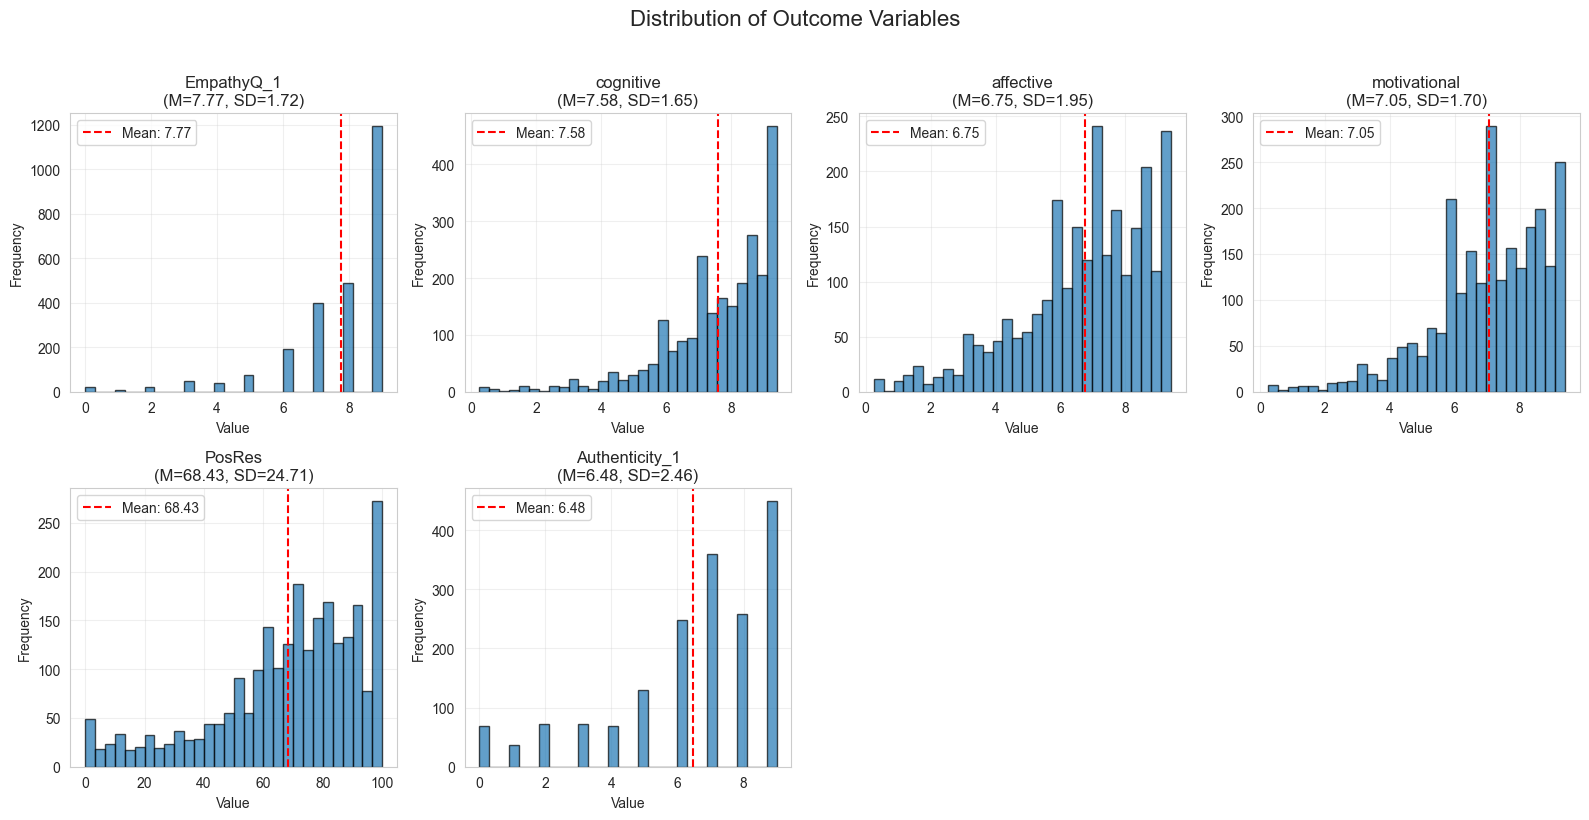

In [26]:
# Visualizations: Outcome distributions
n_vars = len(outcome_vars)
n_cols = 4
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
if n_vars > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for idx, var in enumerate(outcome_vars):
    data = df[var].dropna()
    if len(data) > 0:
        axes[idx].hist(data, bins=30, alpha=0.7, edgecolor='black')
        axes[idx].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.2f}')
        axes[idx].set_title(f'{var}\n(M={data.mean():.2f}, SD={data.std():.2f})')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(outcome_vars), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribution of Outcome Variables', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


**Key Takeaway**: 

**What We're Measuring**: These outcome variables capture participants' ratings of AI responses. **EmpathyQ_1** = general empathy rating (0-9 scale). **cognitive, affective, motivational** = empathy subscales measuring understanding/perspective-taking, emotional resonance, and support/encouragement respectively (0-9.4 scale). **PosRes** = positive response measure (0-100 scale). **Authenticity_1** = perceived authenticity of the response (0-9 scale).

**Distribution Characteristics**: All variables show strong ceiling effects and non-normal distributions. **EmpathyQ_1** has the most severe ceiling effect (47.9% at maximum), meaning nearly half of responses received the highest possible empathy rating. This indicates participants consistently rate AI responses as highly empathetic, with limited variation at the high end. All distributions are significantly non-normal (Shapiro-Wilk p < 0.001), showing left-skewed patterns where most ratings cluster near the maximum. The high means (e.g., EmpathyQ_1 = 7.77/9, cognitive = 7.58/9.4) combined with ceiling effects suggest either: (1) the rating scales lack sensitivity to capture variation in perceived empathy quality, (2) participants are reluctant to give low ratings to empathetic responses, or (3) the AI responses genuinely receive consistently high ratings. This ceiling effect constrains our ability to detect differences between conditions or response types at the high end of the scale, potentially masking effects. Non-parametric statistical tests are recommended given the non-normal distributions.

# section 8.1
Empathy Dimension Correlations Across Studies".
The script will:
Compute correlations between cognitive, affective, and motivational empathy for each study separately
Display correlation matrices for each study
Compare correlations statistically using Fisher's z-transformation
Create visualizations (heatmaps and bar charts)
Provide interpretation guidance
This will show whether Study 3's targeted prompts create more distinct empathy dimensions (lower correlations) or maintain similar relationships to Studies 1a/1b.


EMPATHY DIMENSION CORRELATIONS: Within-Study Analysis

--------------------------------------------------------------------------------
CORRELATION COEFFICIENTS BY STUDY
--------------------------------------------------------------------------------
Pair                      Study 1a        Study 1b        Study 3         Difference (3-1a)
--------------------------------------------------------------------------------
cognitive-affective                0.757          0.744          0.761          0.003
cognitive-motivational             0.737          0.749          0.765          0.028
affective-motivational             0.765          0.753          0.785          0.020

--------------------------------------------------------------------------------
STATISTICAL COMPARISON OF CORRELATIONS
--------------------------------------------------------------------------------
Testing if correlations differ significantly between Study 3 and Studies 1a/1b
(Using Fisher's z-transformation for

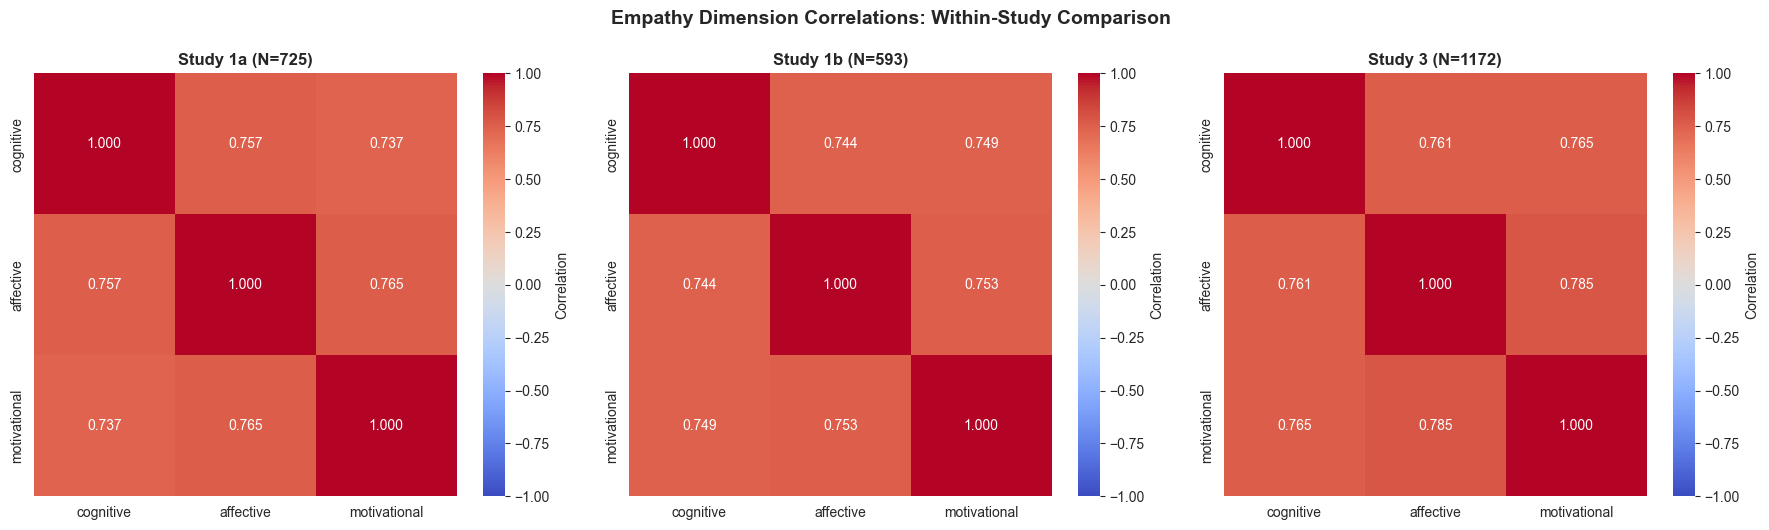

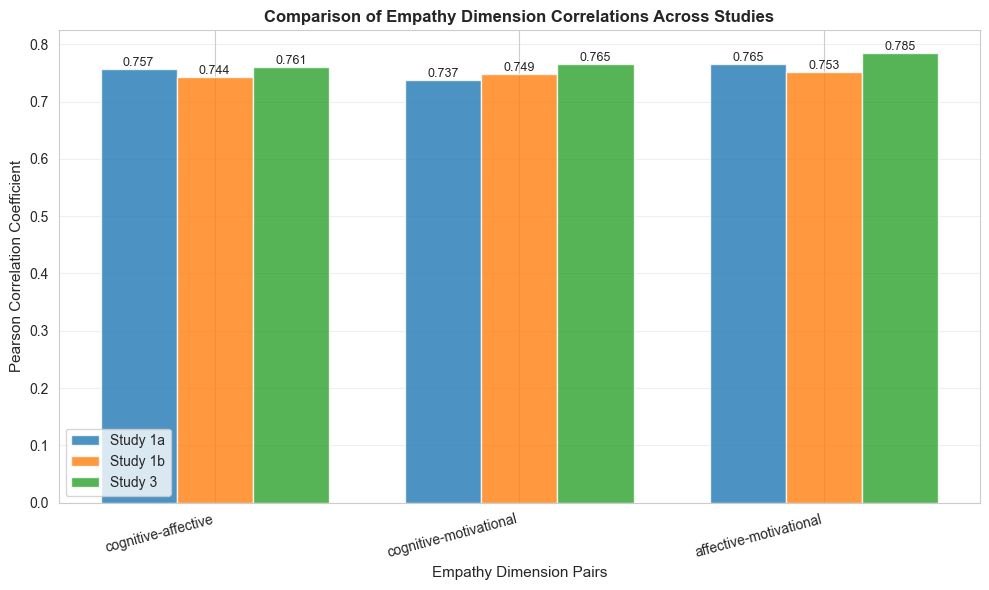


INTERPRETATION

**Key Questions:**
1. Are empathy dimensions more or less correlated in Study 3 (targeted prompts) vs Studies 1a/1b (general prompts)?
2. Do targeted prompts create more distinct empathy dimensions (lower correlations)?
3. Or do dimensions remain similarly correlated across all studies?

**Pattern to look for:**
- If Study 3 correlations are LOWER: Targeted prompts may create more distinct, specialized empathy dimensions
- If Study 3 correlations are HIGHER: Targeted prompts may not differentiate dimensions, or participants rate them similarly
- If correlations are SIMILAR: Empathy dimensions maintain consistent relationships regardless of prompt type


In [44]:
# Correlation analysis: Empathy dimensions within each study
print("\n" + "="*80)
print("EMPATHY DIMENSION CORRELATIONS: Within-Study Analysis")
print("="*80)

# Prepare study data
study1a_corr = study1a_data[['cognitive', 'affective', 'motivational']].dropna()
study1b_corr = study1b_data[['cognitive', 'affective', 'motivational']].dropna()
study3_corr = study3_data[['cognitive', 'affective', 'motivational']].dropna()

# Compute correlations for each study
corr_1a = study1a_corr.corr()
corr_1b = study1b_corr.corr()
corr_3 = study3_corr.corr()

# Extract pairwise correlations
empathy_pairs = [
    ('cognitive', 'affective'),
    ('cognitive', 'motivational'),
    ('affective', 'motivational')
]

print("\n" + "-"*80)
print("CORRELATION COEFFICIENTS BY STUDY")
print("-"*80)
print(f"{'Pair':<25} {'Study 1a':<15} {'Study 1b':<15} {'Study 3':<15} {'Difference (3-1a)':<15}")
print("-"*80)

correlation_comparison = []
for pair in empathy_pairs:
    r1a = corr_1a.loc[pair[0], pair[1]]
    r1b = corr_1b.loc[pair[0], pair[1]]
    r3 = corr_3.loc[pair[0], pair[1]]
    diff = r3 - r1a
    
    pair_name = f"{pair[0]}-{pair[1]}"
    print(f"{pair_name:<25} {r1a:>14.3f} {r1b:>14.3f} {r3:>14.3f} {diff:>14.3f}")
    
    correlation_comparison.append({
        'Pair': pair_name,
        'Study_1a': r1a,
        'Study_1b': r1b,
        'Study_3': r3,
        'Diff_3_vs_1a': diff,
        'Diff_3_vs_1b': r3 - r1b
    })

# Statistical comparison using Fisher's z-transformation
print("\n" + "-"*80)
print("STATISTICAL COMPARISON OF CORRELATIONS")
print("-"*80)
print("Testing if correlations differ significantly between Study 3 and Studies 1a/1b")
print("(Using Fisher's z-transformation for correlation comparison)")

from scipy.stats import fisher_exact
from scipy import stats

def compare_correlations(r1, n1, r2, n2):
    """Compare two correlations using Fisher's z-transformation."""
    # Fisher's z-transformation
    z1 = 0.5 * np.log((1 + r1) / (1 - r1))
    z2 = 0.5 * np.log((1 + r2) / (1 - r2))
    
    # Standard error
    se1 = 1 / np.sqrt(n1 - 3)
    se2 = 1 / np.sqrt(n2 - 3)
    
    # Z-test
    z_diff = (z1 - z2) / np.sqrt(se1**2 + se2**2)
    p_value = 2 * (1 - stats.norm.cdf(abs(z_diff)))
    
    return z_diff, p_value

print(f"\n{'Pair':<25} {'Study 1a vs 3':<20} {'Study 1b vs 3':<20}")
print("-"*80)

n1a = len(study1a_corr)
n1b = len(study1b_corr)
n3 = len(study3_corr)

for pair in empathy_pairs:
    r1a = corr_1a.loc[pair[0], pair[1]]
    r1b = corr_1b.loc[pair[0], pair[1]]
    r3 = corr_3.loc[pair[0], pair[1]]
    
    pair_name = f"{pair[0]}-{pair[1]}"
    
    # Compare Study 3 vs Study 1a
    z_diff_1a, p_1a = compare_correlations(r3, n3, r1a, n1a)
    sig_1a = "*" if p_1a < 0.05 else ""
    
    # Compare Study 3 vs Study 1b
    z_diff_1b, p_1b = compare_correlations(r3, n3, r1b, n1b)
    sig_1b = "*" if p_1b < 0.05 else ""
    
    print(f"{pair_name:<25} z={z_diff_1a:>6.3f}, p={p_1a:>6.4f}{sig_1a:<2}  z={z_diff_1b:>6.3f}, p={p_1b:>6.4f}{sig_1b}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Study 1a correlation heatmap
sns.heatmap(corr_1a, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title(f'Study 1a (N={n1a})', fontsize=12, fontweight='bold')

# Study 1b correlation heatmap
sns.heatmap(corr_1b, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title(f'Study 1b (N={n1b})', fontsize=12, fontweight='bold')

# Study 3 correlation heatmap
sns.heatmap(corr_3, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[2], cbar_kws={'label': 'Correlation'})
axes[2].set_title(f'Study 3 (N={n3})', fontsize=12, fontweight='bold')

plt.suptitle('Empathy Dimension Correlations: Within-Study Comparison', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Bar plot comparing correlations across studies
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(len(empathy_pairs))
width = 0.25

r1a_vals = [corr_1a.loc[p[0], p[1]] for p in empathy_pairs]
r1b_vals = [corr_1b.loc[p[0], p[1]] for p in empathy_pairs]
r3_vals = [corr_3.loc[p[0], p[1]] for p in empathy_pairs]

pair_labels = [f"{p[0]}-{p[1]}" for p in empathy_pairs]

bars1 = ax.bar(x - width, r1a_vals, width, label='Study 1a', alpha=0.8)
bars2 = ax.bar(x, r1b_vals, width, label='Study 1b', alpha=0.8)
bars3 = ax.bar(x + width, r3_vals, width, label='Study 3', alpha=0.8)

ax.set_xlabel('Empathy Dimension Pairs', fontsize=11)
ax.set_ylabel('Pearson Correlation Coefficient', fontsize=11)
ax.set_title('Comparison of Empathy Dimension Correlations Across Studies', 
             fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pair_labels, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Summary interpretation
print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("\n**Key Questions:**")
print("1. Are empathy dimensions more or less correlated in Study 3 (targeted prompts) vs Studies 1a/1b (general prompts)?")
print("2. Do targeted prompts create more distinct empathy dimensions (lower correlations)?")
print("3. Or do dimensions remain similarly correlated across all studies?")
print("\n**Pattern to look for:**")
print("- If Study 3 correlations are LOWER: Targeted prompts may create more distinct, specialized empathy dimensions")
print("- If Study 3 correlations are HIGHER: Targeted prompts may not differentiate dimensions, or participants rate them similarly")
print("- If correlations are SIMILAR: Empathy dimensions maintain consistent relationships regardless of prompt type")

### Section 9: Correlations Between Outcome Measures

**Purpose**: Identify redundancy and latent structure


CORRELATION MATRIX: OUTCOME VARIABLES

Pearson Correlation Matrix:
                EmpathyQ_1  cognitive  affective  motivational  PosRes  \
EmpathyQ_1           1.000      0.768      0.719         0.726   0.709   
cognitive            0.768      1.000      0.755         0.759   0.729   
affective            0.719      0.755      1.000         0.777   0.773   
motivational         0.726      0.759      0.777         1.000   0.744   
PosRes               0.709      0.729      0.773         0.744   1.000   
Authenticity_1       0.700      0.712      0.716         0.707   0.753   

                Authenticity_1  
EmpathyQ_1               0.700  
cognitive                0.712  
affective                0.716  
motivational             0.707  
PosRes                   0.753  
Authenticity_1           1.000  

HIGH CORRELATIONS (r > 0.7) - Potential Redundancy:
  EmpathyQ_1 ↔ cognitive: r = 0.768
  EmpathyQ_1 ↔ affective: r = 0.719
  EmpathyQ_1 ↔ motivational: r = 0.726
  EmpathyQ_1 ↔ PosR

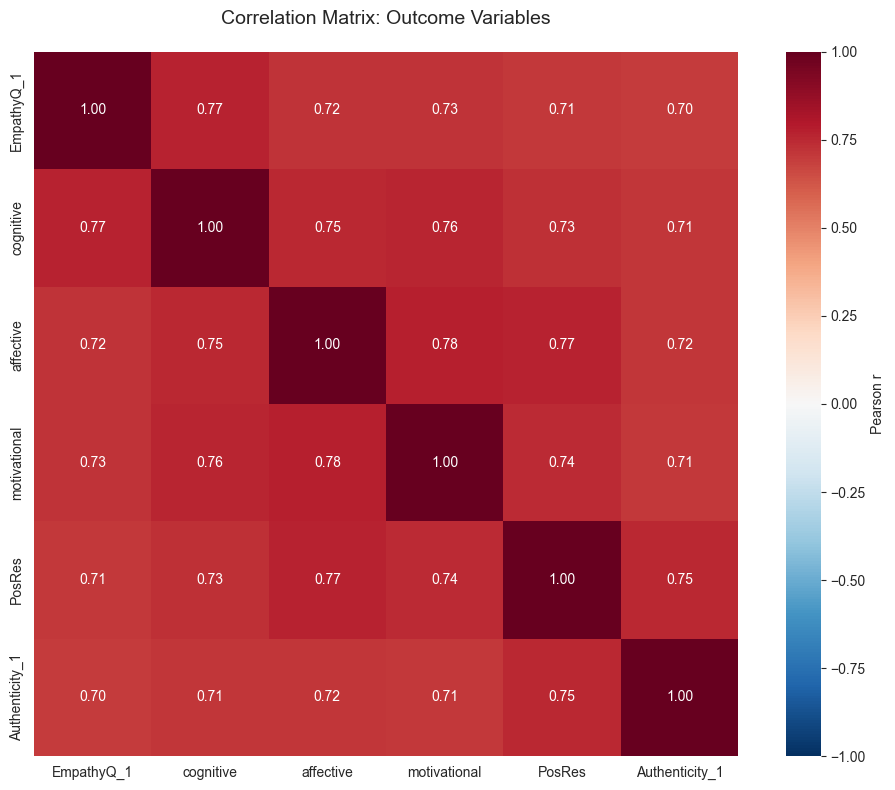

In [27]:
# Correlation matrix for outcome variables
outcome_data = df[outcome_vars].dropna()

if len(outcome_data) > 0:
    print("="*80)
    print("CORRELATION MATRIX: OUTCOME VARIABLES")
    print("="*80)
    
    corr_matrix = outcome_data.corr()
    print("\nPearson Correlation Matrix:")
    print(corr_matrix.round(3))
    
    # Identify high correlations (> 0.7)
    print("\n" + "="*80)
    print("HIGH CORRELATIONS (r > 0.7) - Potential Redundancy:")
    print("="*80)
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
    
    if high_corr_pairs:
        for var1, var2, r in high_corr_pairs:
            print(f"  {var1} ↔ {var2}: r = {r:.3f}")
    else:
        print("  No correlations > 0.7 found.")
    
    # Visualize correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                vmin=-1, vmax=1, square=True, fmt='.2f',
                cbar_kws={'label': 'Pearson r'})
    plt.title('Correlation Matrix: Outcome Variables', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient data for correlation analysis.")


**Key Takeaway**: 

**What We're Measuring**: The correlation matrix examines relationships between different participant rating dimensions: general empathy (EmpathyQ_1), empathy subscales (cognitive, affective, motivational), positive response (PosRes), and authenticity (Authenticity_1).

**Findings**: All outcome variables show strong positive correlations (r = 0.70-0.78), with all 15 pairwise correlations exceeding 0.70. The highest correlation is between affective and motivational empathy (r = 0.777), suggesting these dimensions are particularly closely related. General empathy (EmpathyQ_1) correlates strongly with all subscales (r = 0.72-0.77), indicating it captures a common factor across empathy dimensions.

**Interpretation**: The high correlations indicate substantial redundancy—these variables measure overlapping constructs. This suggests participants' ratings reflect a general positive evaluation factor rather than distinct, independent dimensions. The strong intercorrelations (all r > 0.70) mean that responses rated highly on one dimension tend to be rated highly on all others. This redundancy has implications for analysis: (1) using all variables in the same model risks multicollinearity, (2) the variables may tap into a single underlying "perceived empathy quality" factor, and (3) effects found on one outcome are likely to generalize to others. The pattern suggests that participants make holistic judgments about response quality rather than evaluating distinct aspects independently.

### Section 10: Response Type → Outcome Relationships (Study 3)

**Purpose**: Which prompt style gets highest ratings?


In [28]:
# Response Type → Outcome Analysis (Study 3)
if 'response_type_col' in locals() and response_type_col and response_type_col in df.columns:
    study3_outcomes = df[(df['StudyNum'] == '3') & (df[response_type_col].notna())].copy()
    
    print("="*80)
    print("RESPONSE TYPE → OUTCOME RELATIONSHIPS (Study 3)")
    print("="*80)
    
    for outcome in outcome_vars:
        if outcome not in study3_outcomes.columns:
            continue
            
        print(f"\n{'-'*80}")
        print(f"{outcome.upper()}")
        print(f"{'-'*80}")
        
        # Group by response type
        groups = []
        group_names = []
        for rt in sorted(study3_outcomes[response_type_col].unique()):
            group_data = study3_outcomes[study3_outcomes[response_type_col] == rt][outcome].dropna()
            if len(group_data) > 0:
                groups.append(group_data)
                group_names.append(rt)
        
        if len(groups) >= 2:
            # Descriptive statistics
            print(f"\nDescriptive Statistics:")
            for name, group in zip(group_names, groups):
                print(f"  {name}: M={group.mean():.2f}, SD={group.std():.2f}, N={len(group)}")
            
            # One-way ANOVA
            f_stat, p_value = f_oneway(*groups)
            all_data = study3_outcomes[outcome].dropna()
            ss_total = np.sum((all_data - all_data.mean())**2)
            ss_between = sum(len(g) * (g.mean() - all_data.mean())**2 for g in groups)
            eta_sq = eta_squared(ss_between, ss_total)
            
            print(f"\nANOVA: F({len(groups)-1}, {len(all_data)-len(groups)}) = {f_stat:.3f}, p = {p_value:.4f}, η² = {eta_sq:.3f}")
            
            # Post-hoc pairwise tests with Bonferroni correction
            if len(groups) == 3:
                from itertools import combinations
                comparisons = list(combinations(range(len(groups)), 2))
                n_comparisons = len(comparisons)
                bonferroni_alpha = 0.05 / n_comparisons
                
                cohens_d_label = "Cohen's d"
                print(f"\nPost-hoc pairwise comparisons (Bonferroni α = {bonferroni_alpha:.4f}):")
                print(f"{'Comparison':<35} {'Mean Diff':<12} {'t':<10} {'p (adj)':<12} {cohens_d_label:<12}")
                print("-" * 85)
                for i, j in comparisons:
                    t_stat, p_val = ttest_ind(groups[i], groups[j], equal_var=False)
                    d = cohens_d(groups[i], groups[j])
                    sig = '*' if p_val < bonferroni_alpha else ''
                    mean_diff = groups[i].mean() - groups[j].mean()
                    print(f"{group_names[i]} vs {group_names[j]:<20} {mean_diff:>10.3f} {t_stat:>9.3f} {p_val:>10.4f}{sig:<2} {d:>10.3f}")

RESPONSE TYPE → OUTCOME RELATIONSHIPS (Study 3)

--------------------------------------------------------------------------------
EMPATHYQ_1
--------------------------------------------------------------------------------

Descriptive Statistics:
  Affective: M=7.79, SD=1.63, N=132
  Cognitive: M=7.76, SD=1.77, N=860
  Motivational: M=7.51, SD=1.74, N=180

ANOVA: F(2, 1169) = 1.594, p = 0.2036, η² = 0.003

Post-hoc pairwise comparisons (Bonferroni α = 0.0167):
Comparison                          Mean Diff    t          p (adj)      Cohen's d   
-------------------------------------------------------------------------------------
Affective vs Cognitive                 0.029     0.185     0.8535        0.016
Affective vs Motivational              0.277     1.436     0.1521        0.163
Cognitive vs Motivational              0.248     1.731     0.0846        0.141

--------------------------------------------------------------------------------
COGNITIVE
----------------------------------

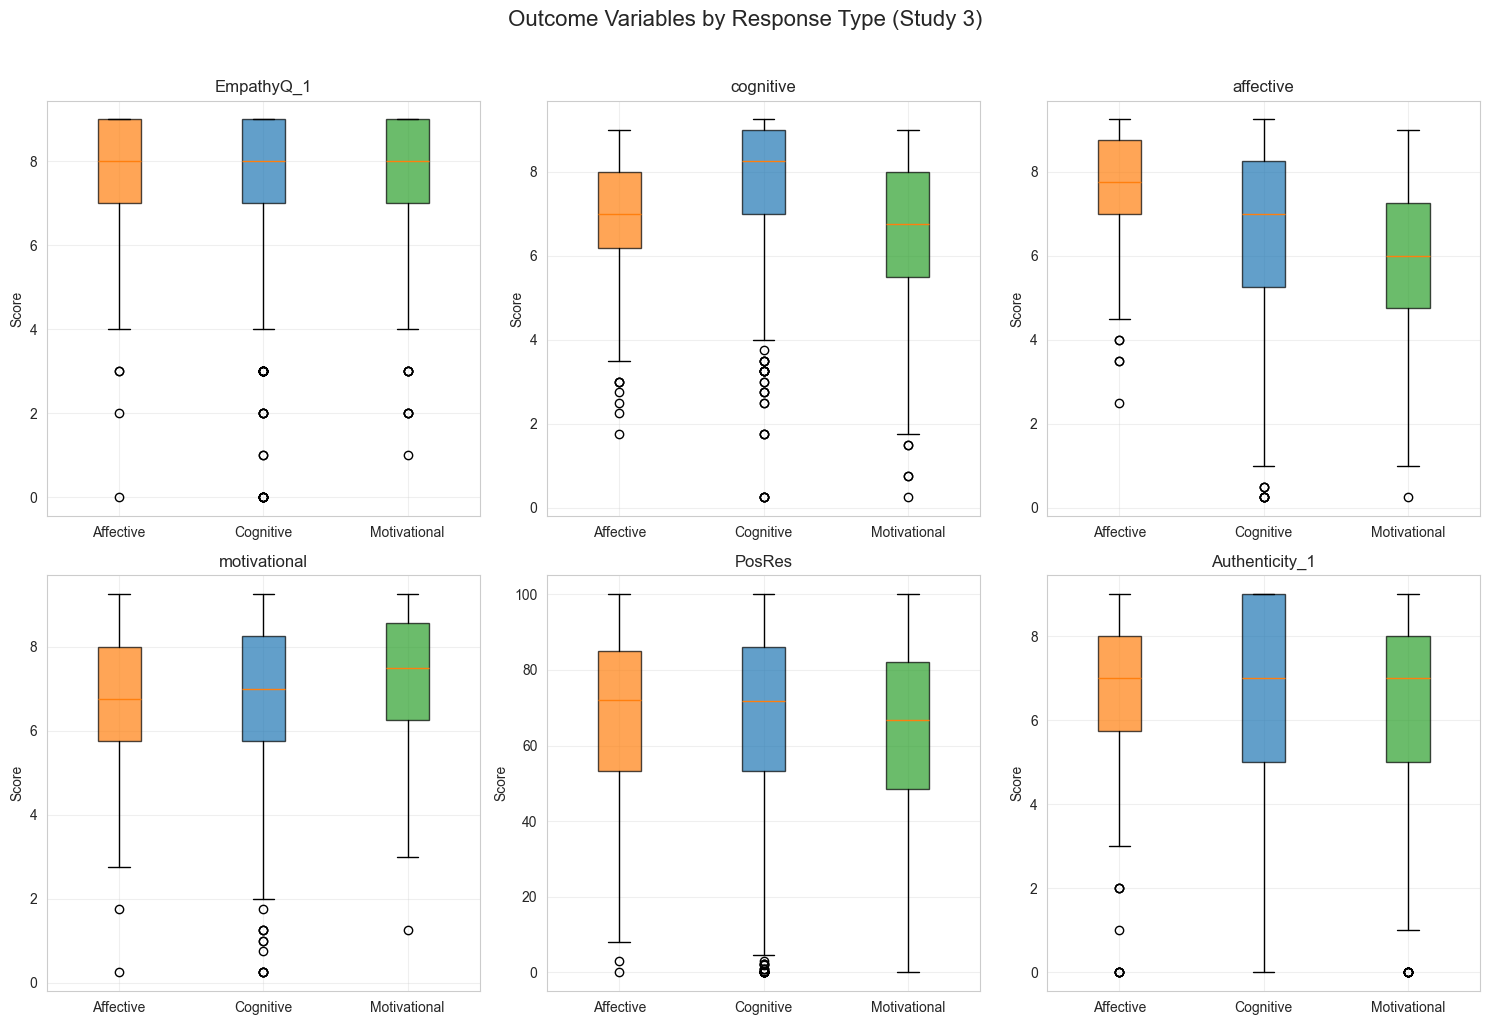

In [29]:
# Visualizations: Outcomes by Response Type (Study 3)
if 'response_type_col' in locals() and response_type_col and response_type_col in df.columns:
    study3_outcomes = df[(df['StudyNum'] == '3') & (df[response_type_col].notna())].copy()
    
    n_outcomes = len([v for v in outcome_vars if v in study3_outcomes.columns])
    n_cols = 3
    n_rows = (n_outcomes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_outcomes > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    plot_idx = 0
    for outcome in outcome_vars:
        if outcome not in study3_outcomes.columns:
            continue
            
        ax = axes[plot_idx]
        
        data_to_plot = []
        labels = []
        colors_list = []
        for rt in sorted(study3_outcomes[response_type_col].unique()):
            group_data = study3_outcomes[study3_outcomes[response_type_col] == rt][outcome].dropna()
            if len(group_data) > 0:
                data_to_plot.append(group_data.values)
                labels.append(rt)
                color = RESPONSE_COLORS.get(rt, '#808080')
                colors_list.append(color)
        
        if data_to_plot:
            bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            for patch, color in zip(bp['boxes'], colors_list):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            ax.set_title(outcome)
            ax.set_ylabel('Score')
            ax.grid(True, alpha=0.3)
        
        plot_idx += 1
    
    # Hide extra subplots
    for idx in range(plot_idx, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Outcome Variables by Response Type (Study 3)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


**Key Takeaway**: Response types show strong, specific effects on their corresponding empathy subscales, validating the experimental manipulation. **Cognitive responses** score highest on cognitive empathy (M=7.79 vs 6.87/6.53, d=0.58-0.77, p<0.001), **Affective responses** score highest on affective empathy (M=7.63 vs 6.50/5.88, d=0.55-1.02, p<0.001), and **Motivational responses** score highest on motivational empathy (M=7.36 vs 6.70/6.74, d=0.35-0.43, p<0.001). This pattern indicates participants successfully distinguished between empathy styles and rated responses higher on the dimension they were designed to emphasize. However, **general empathy (EmpathyQ_1)** shows no significant differences ac

### Section 11: Response Type × Condition Interaction (Study 3)

**Purpose**: Does the "human advantage" vary by response type?


In [30]:
# Two-way ANOVA: ResponseType × Condition (Study 3)
if 'response_type_col' in locals() and response_type_col and response_type_col in df.columns:
    study3_interaction = df[(df['StudyNum'] == '3') & (df[response_type_col].notna())].copy()
    
    print("="*80)
    print("RESPONSE TYPE × CONDITION INTERACTION (Study 3)")
    print("="*80)
    
    for outcome in outcome_vars:
        if outcome not in study3_interaction.columns:
            continue
            
        print(f"\n{'-'*80}")
        print(f"{outcome.upper()}")
        print(f"{'-'*80}")
        
        # Prepare data for two-way ANOVA
        data_clean = study3_interaction[[outcome, response_type_col, 'Condition']].dropna()
        
        if len(data_clean) > 0:
            # Two-way ANOVA using statsmodels
            try:
                from statsmodels.formula.api import ols
                from statsmodels.stats.anova import anova_lm
                
                formula = f"{outcome} ~ C({response_type_col}) + C(Condition) + C({response_type_col}):C(Condition)"
                model = ols(formula, data=data_clean).fit()
                anova_table = anova_lm(model, typ=2)
                
                print("\nTwo-way ANOVA Results:")
                print(anova_table)
                
                # Extract effect sizes (eta-squared)
                ss_total = ((data_clean[outcome] - data_clean[outcome].mean())**2).sum()
                print(f"\nEffect Sizes (η²):")
                for idx, row in anova_table.iterrows():
                    eta_sq = row['sum_sq'] / ss_total
                    print(f"  {idx}: η² = {eta_sq:.3f}")
                
                # Simple effects: Condition effect within each ResponseType
                cohens_d_label = "Cohen's d"
                print(f"\nSimple Effects: Condition (Human - AI) within each ResponseType:")
                print(f"{'ResponseType':<20} {'Human - AI':<12} {'t':<10} {'p':<12} {cohens_d_label:<12}")
                print("-" * 70)
                
                for rt in sorted(data_clean[response_type_col].unique()):
                    rt_data = data_clean[data_clean[response_type_col] == rt]
                    human_data = rt_data[rt_data['Condition'] == 'Human'][outcome]
                    ai_data = rt_data[rt_data['Condition'] == 'AI'][outcome]
                    
                    if len(human_data) > 0 and len(ai_data) > 0:
                        t_stat, p_val = ttest_ind(human_data, ai_data, equal_var=False)
                        d = cohens_d(human_data, ai_data)
                        mean_diff = human_data.mean() - ai_data.mean()
                        print(f"{rt:<20} {mean_diff:>10.3f} {t_stat:>9.3f} {p_val:>10.4f} {d:>10.3f}")
                
            except ImportError:
                print("Note: statsmodels not available. Install with: pip install statsmodels")
                print("Using alternative approach...")
                
                # Alternative: Manual calculation
                print("\nGroup means:")
                means = data_clean.groupby([response_type_col, 'Condition'])[outcome].mean()
                print(means)
                
                # Simple effects manually
                print(f"\nSimple Effects: Condition (Human - AI) within each ResponseType:")
                for rt in sorted(data_clean[response_type_col].unique()):
                    rt_data = data_clean[data_clean[response_type_col] == rt]
                    human_data = rt_data[rt_data['Condition'] == 'Human'][outcome]
                    ai_data = rt_data[rt_data['Condition'] == 'AI'][outcome]
                    
                    if len(human_data) > 0 and len(ai_data) > 0:
                        t_stat, p_val = ttest_ind(human_data, ai_data, equal_var=False)
                        d = cohens_d(human_data, ai_data)
                        mean_diff = human_data.mean() - ai_data.mean()
                        print(f"  {rt}: Mean diff = {mean_diff:.3f}, t = {t_stat:.3f}, p = {p_val:.4f}, d = {d:.3f}")

RESPONSE TYPE × CONDITION INTERACTION (Study 3)

--------------------------------------------------------------------------------
EMPATHYQ_1
--------------------------------------------------------------------------------

Two-way ANOVA Results:
                                   sum_sq      df          F    PR(>F)
C(ResponseType)                  7.543654     2.0   1.255310  0.285372
C(Condition)                    50.531702     1.0  16.817562  0.000044
C(ResponseType):C(Condition)    28.203977     2.0   4.693313  0.009330
Residual                      3503.478286  1166.0        NaN       NaN

Effect Sizes (η²):
  C(ResponseType): η² = 0.002
  C(Condition): η² = 0.014
  C(ResponseType):C(Condition): η² = 0.008
  Residual: η² = 0.975

Simple Effects: Condition (Human - AI) within each ResponseType:
ResponseType         Human - AI   t          p            Cohen's d   
----------------------------------------------------------------------
Affective                -0.455    -1.607     0.

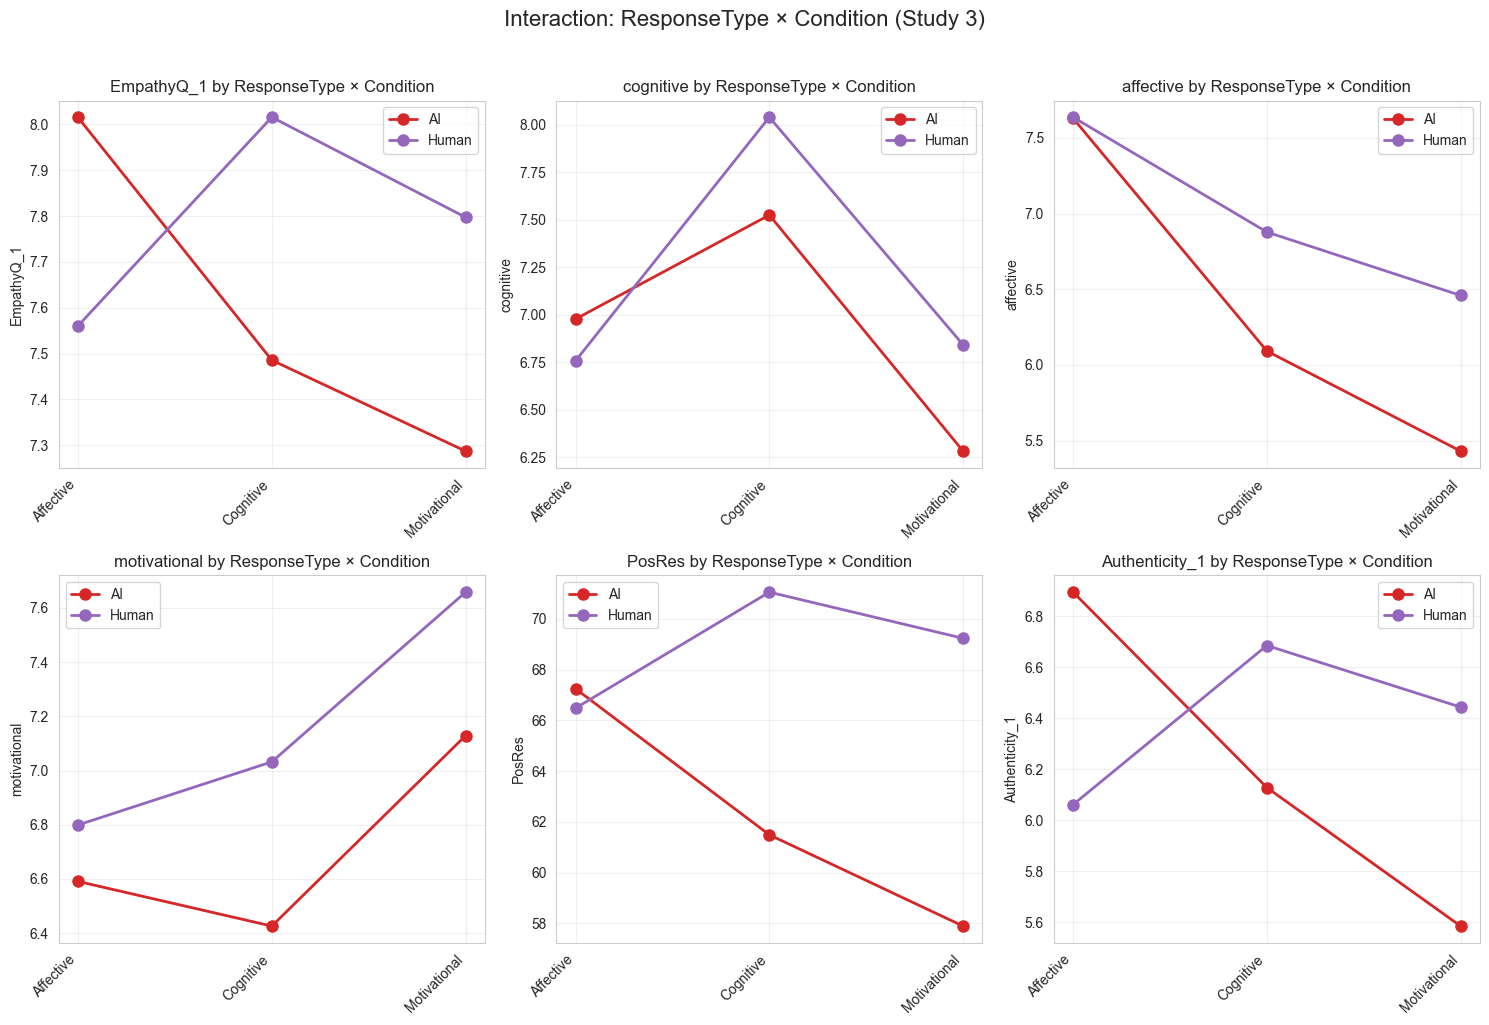

In [31]:
# Interaction plots: ResponseType × Condition (Study 3)
if 'response_type_col' in locals() and response_type_col and response_type_col in df.columns:
    study3_interaction = df[(df['StudyNum'] == '3') & (df[response_type_col].notna())].copy()
    
    n_outcomes = len([v for v in outcome_vars if v in study3_interaction.columns])
    n_cols = 3
    n_rows = (n_outcomes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_outcomes > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    plot_idx = 0
    for outcome in outcome_vars:
        if outcome not in study3_interaction.columns:
            continue
            
        ax = axes[plot_idx]
        
        # Create interaction plot
        interaction_data = study3_interaction.groupby([response_type_col, 'Condition'])[outcome].mean().reset_index()
        
        for condition in ['AI', 'Human']:
            cond_data = interaction_data[interaction_data['Condition'] == condition]
            x_pos = range(len(cond_data[response_type_col]))
            ax.plot(x_pos, cond_data[outcome], marker='o', label=condition, 
                   color=CONDITION_COLORS[condition], linewidth=2, markersize=8)
        
        ax.set_xticks(range(len(interaction_data[response_type_col].unique())))
        ax.set_xticklabels(sorted(interaction_data[response_type_col].unique()), rotation=45, ha='right')
        ax.set_ylabel(outcome)
        ax.set_title(f'{outcome} by ResponseType × Condition')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1
    
    # Hide extra subplots
    for idx in range(plot_idx, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Interaction: ResponseType × Condition (Study 3)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


**Key Takeaway**: The "human advantage" (higher ratings when responses are labeled as Human vs AI) varies significantly by response type, revealing a critical interaction. **Main effects** show consistent human advantage across outcomes (all p < 0.01, η² = 0.008-0.031), but **interactions** are significant for general empathy (EmpathyQ_1, p=0.009), cognitive empathy (p=0.045), and authenticity (p=0.006). **Simple effects** reveal a clear pattern: the human advantage is strongest for **Cognitive responses** (d=0.22-0.38, all p<0.001), moderate for **Motivational responses** (d=0.30-0.55, p<0.05), and **absent or reversed for Affective responses** (d=-0.28 to 0.01, all p>0.05). This suggests that participants' bias toward human responses is most pronounced when evaluating cognitive/analytical empathy, but minimal when evaluating emotional/affective empathy. The crossover interactions (visible in plots) indicate that for Affective responses, AI-labeled responses sometimes score as high or higher than Human-labeled responses, challenging the assumption of a uniform human advantage. This pattern suggests that affective empathy may be perceived as more "authentic" or "natural" when attributed to AI, or that participants are less biased when evaluating emotional responses.

**Important Contradiction with Study 1b**: This finding **contradicts** the pattern reported in Study 1b, where the interaction between condition and empathy aspect showed that the human advantage was **larger for affective empathy** than for cognitive empathy (F(2, 1126.97) = 4.09, P = 0.02; post-hoc: affective difference > cognitive difference, t(1147) = 2.82, P = 0.02). In Study 3, we observe the **opposite pattern**: the human advantage is strongest for cognitive responses and absent/reversed for affective responses. This discrepancy could reflect: (1) methodological differences between studies (Study 1b examined empathy aspects as within-subject factors, while Study 3 classifies responses post-hoc by dominant empathy type); (2) differences in how participants evaluate responses when they know the specific empathy dimension being measured vs. when they evaluate responses holistically; or (3) genuine differences in how the human advantage manifests across different experimental contexts. This contradiction highlights the importance of considering both the measurement approach and the experimental design when interpreting interaction effects.

### Section 12: Text Features → Outcome Correlations

**Purpose**: Which text characteristics predict empathy ratings?


In [32]:
# Collect all text features
text_feature_cols = []
for prefix in ['length_', 'dominance_', 'diversity_', 'mimicry_']:
    matching_cols = [col for col in df.columns if col.startswith(prefix)]
    text_feature_cols.extend(matching_cols)

print(f"Text features found: {len(text_feature_cols)}")
print(f"Sample features: {text_feature_cols[:10]}")

# Filter to Study 3 with valid data
study3_features = df[df['StudyNum'] == '3'].copy()
study3_features = study3_features[study3_features['length_char_count'] > 0].copy()

print(f"\nStudy 3 responses with valid text features: {len(study3_features)}")


Text features found: 16
Sample features: ['length_word_count', 'length_sentence_count', 'length_char_count', 'length_avg_word_length', 'length_avg_sentence_length', 'dominance_top_10_coverage', 'dominance_top_20_coverage', 'dominance_top_50_coverage', 'dominance_gini_coefficient', 'diversity_ttr']

Study 3 responses with valid text features: 1171


In [33]:
# Correlate text features with outcomes (Study 3)
print("="*80)
print("TEXT FEATURES → OUTCOME CORRELATIONS (Study 3)")
print("="*80)

feature_outcome_corrs = []

for outcome in outcome_vars:
    if outcome not in study3_features.columns:
        continue
    
    for feature in text_feature_cols:
        if feature not in study3_features.columns:
            continue
        
        valid_data = study3_features[[outcome, feature]].dropna()
        if len(valid_data) >= 3:
            r_pearson, p_pearson = pearsonr(valid_data[outcome], valid_data[feature])
            r_spearman, p_spearman = spearmanr(valid_data[outcome], valid_data[feature])
            
            feature_outcome_corrs.append({
                'outcome': outcome,
                'text_feature': feature,
                'pearson_r': r_pearson,
                'pearson_p': p_pearson,
                'spearman_r': r_spearman,
                'spearman_p': p_spearman
            })

corr_df_features = pd.DataFrame(feature_outcome_corrs)

# Apply FDR correction for multiple comparisons
from statsmodels.stats.multitest import multipletests

if len(corr_df_features) > 0:
    # FDR correction on Spearman p-values
    _, p_corrected, _, _ = multipletests(corr_df_features['spearman_p'], alpha=0.05, method='fdr_bh')
    corr_df_features['spearman_p_fdr'] = p_corrected
    
    # Display results by outcome
    for outcome in outcome_vars:
        subset = corr_df_features[corr_df_features['outcome'] == outcome].copy()
        if len(subset) > 0:
            subset = subset.sort_values('spearman_r', key=abs, ascending=False)
            
            print(f"\n{'-'*80}")
            print(f"{outcome.upper()}")
            print(f"{'-'*80}")
            print(f"{'Text Feature':<35} {'Spearman r':<12} {'p (FDR)':<12} {'Pearson r':<12} {'p':<12}")
            print("-" * 85)
            
            for _, row in subset.head(15).iterrows():
                sig_s = '*' if row['spearman_p_fdr'] < 0.05 else ''
                sig_p = '*' if row['pearson_p'] < 0.05 else ''
                feat_name = row['text_feature'].replace('length_', '').replace('dominance_', '').replace('diversity_', '').replace('mimicry_', '')
                print(f"{feat_name:<35} {row['spearman_r']:>10.3f}{sig_s:<2} {row['spearman_p_fdr']:>10.4f} {row['pearson_r']:>10.3f}{sig_p:<2} {row['pearson_p']:>10.4f}")
            
            n_sig = (subset['spearman_p_fdr'] < 0.05).sum()
            print(f"\nSignificant correlations (FDR-corrected): {n_sig}/{len(subset)}")


TEXT FEATURES → OUTCOME CORRELATIONS (Study 3)

--------------------------------------------------------------------------------
EMPATHYQ_1
--------------------------------------------------------------------------------
Text Feature                        Spearman r   p (FDR)      Pearson r    p           
-------------------------------------------------------------------------------------
top_50_coverage                         -0.067       0.1100     -0.049       0.0935
sentence_count                           0.058       0.1303      0.059*      0.0451
rttr                                     0.048       0.2354      0.072*      0.0143
top_10_coverage                         -0.048       0.2354     -0.073*      0.0128
top_20_coverage                         -0.046       0.2374     -0.068*      0.0194
word_count                               0.042       0.2902      0.061*      0.0378
shared_content_words                     0.037       0.3149      0.024       0.4194
char_count       

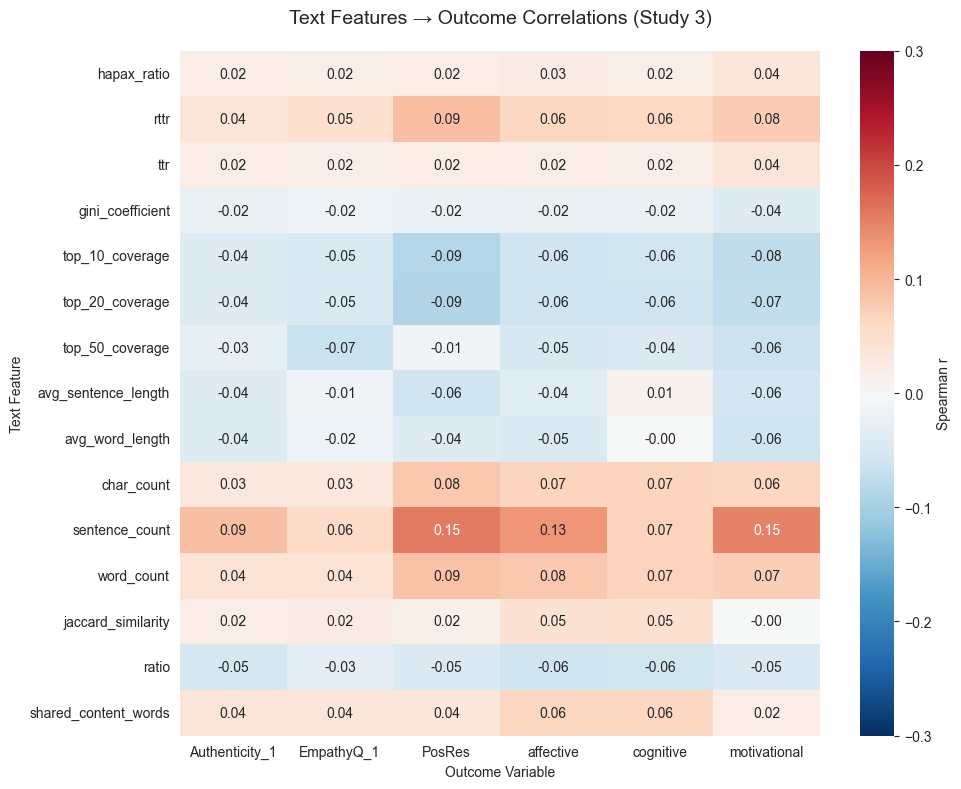


STRONGEST CORRELATIONS: Scatter Plots


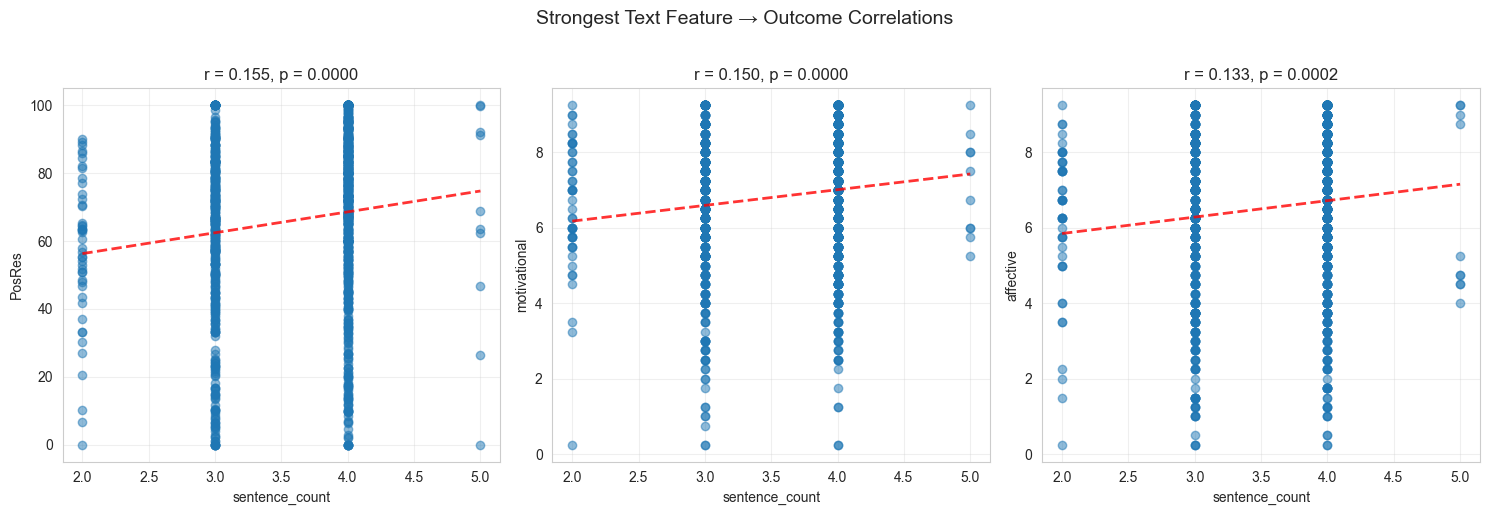

In [34]:
# Heatmap: Text Features × Outcomes
if len(corr_df_features) > 0:
    # Create pivot table for heatmap
    pivot_data = corr_df_features.pivot(index='text_feature', columns='outcome', values='spearman_r')
    
    # Clean feature names for display
    pivot_data.index = [idx.replace('length_', '').replace('dominance_', '').replace('diversity_', '').replace('mimicry_', '') 
                        for idx in pivot_data.index]
    
    plt.figure(figsize=(10, max(8, len(pivot_data) * 0.3)))
    sns.heatmap(pivot_data, annot=True, cmap='RdBu_r', center=0, 
                vmin=-0.3, vmax=0.3, fmt='.2f', cbar_kws={'label': 'Spearman r'})
    plt.title('Text Features → Outcome Correlations (Study 3)', fontsize=14, pad=20)
    plt.xlabel('Outcome Variable')
    plt.ylabel('Text Feature')
    plt.tight_layout()
    plt.show()
    
    # Scatter plots for strongest correlations
    print("\n" + "="*80)
    print("STRONGEST CORRELATIONS: Scatter Plots")
    print("="*80)
    
    # Find top 3 strongest correlations
    corr_df_features['abs_spearman'] = corr_df_features['spearman_r'].abs()
    top_corrs = corr_df_features.nlargest(3, 'abs_spearman')
    
    if len(top_corrs) > 0:
        fig, axes = plt.subplots(1, min(3, len(top_corrs)), figsize=(5*min(3, len(top_corrs)), 5))
        if len(top_corrs) == 1:
            axes = [axes]
        
        for idx, (_, row) in enumerate(top_corrs.iterrows()):
            ax = axes[idx]
            feature = row['text_feature']
            outcome = row['outcome']
            
            valid_data = study3_features[[outcome, feature]].dropna()
            if len(valid_data) > 0:
                ax.scatter(valid_data[feature], valid_data[outcome], alpha=0.5)
                
                # Add regression line
                z = np.polyfit(valid_data[feature], valid_data[outcome], 1)
                p = np.poly1d(z)
                ax.plot(valid_data[feature].sort_values(), p(valid_data[feature].sort_values()), 
                       "r--", alpha=0.8, linewidth=2)
                
                ax.set_xlabel(feature.replace('length_', '').replace('dominance_', '').replace('diversity_', '').replace('mimicry_', ''))
                ax.set_ylabel(outcome)
                ax.set_title(f'r = {row["spearman_r"]:.3f}, p = {row["spearman_p_fdr"]:.4f}')
                ax.grid(True, alpha=0.3)
        
        plt.suptitle('Strongest Text Feature → Outcome Correlations', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()


**Key Takeaway**: Text features show **weak but statistically significant** correlations with empathy outcomes, with **sentence count** emerging as the most consistent predictor. After FDR correction for multiple comparisons, only **7 out of 90 correlations** (15 features × 6 outcomes) remain significant, highlighting the overall weak relationship between surface-level text characteristics and empathy ratings.

**Patterns Across Outcomes**:

1. **Sentence Count** is the strongest and most consistent predictor:
   - PosRes: r = 0.155 (p < 0.001, FDR-corrected)
   - Motivational: r = 0.150 (p < 0.001, FDR-corrected)
   - Affective: r = 0.133 (p < 0.001, FDR-corrected)
   - Authenticity_1: r = 0.090 (p = 0.030, FDR-corrected)
   - Cognitive: r = 0.070 (p = 0.104, not significant after FDR)
   - EmpathyQ_1: r = 0.058 (p = 0.130, not significant after FDR)
   
   This suggests that responses with more sentences (typically 3-5 sentences) tend to receive slightly higher empathy ratings, particularly for affective and motivational empathy dimensions. This may reflect that longer, more structured responses are perceived as more thoughtful or complete.

2. **Word Dominance Metrics** (top_N_coverage) show consistent **negative** correlations:
   - Higher concentration of frequent words (less lexical diversity) is associated with lower empathy ratings
   - PosRes shows significant negative correlations with top_10_coverage (r = -0.087) and top_20_coverage (r = -0.090)
   - This suggests that responses relying heavily on common words may be perceived as less empathetic

3. **Length Features** (word_count, char_count) show small positive correlations:
   - Longer responses tend to score slightly higher, but effects are weak (r < 0.10)
   - This aligns with the sentence count finding, suggesting that more extensive responses are rated more favorably

4. **Lexical Diversity** (rttr) shows small positive correlations:
   - PosRes: r = 0.089 (p = 0.030, FDR-corrected)
   - Suggests that more diverse vocabulary is associated with higher positive response ratings

5. **Style Mimicry Features** (ratio, jaccard_similarity, shared_content_words) show minimal relationships:
   - Most correlations are near zero, suggesting that mimicking the prompt's style does not strongly predict empathy ratings
   - This aligns with earlier findings showing limited mimicry effects

**Interpretation**: The weak correlations suggest that **surface-level text features explain very little variance** in empathy ratings (likely < 3% based on r² values). This indicates that empathy perception is driven more by **semantic content, emotional tone, or other deeper linguistic features** (potentially captured by embeddings) rather than simple structural characteristics like length, word frequency, or lexical diversity. The fact that sentence count shows the strongest relationship may reflect that participants value responses that feel "complete" or "thoughtful" (multiple sentences) rather than brief acknowledgments, but even this effect is small. The scarcity of significant correlations after FDR correction suggests that most observed relationships could be spurious or context-dependent, reinforcing the need for more sophisticated text analysis approaches (e.g., semantic embeddings, sentiment analysis) to understand what makes responses feel empathetic.

### Section 13: Studies 1a & 1b Overview

**Purpose**: Characterize test set; check for distribution shift


In [35]:
# Studies 1a & 1b Overview
study1a_data = df[df['StudyNum'] == '1'].copy()
study1b_data = df[df['StudyNum'] == '1b'].copy()
study3_data = df[df['StudyNum'] == '3'].copy()

print("="*80)
print("STUDIES 1A & 1B OVERVIEW")
print("="*80)

print(f"\nSample Sizes:")
print(f"  Study 1a: {len(study1a_data)} (AI: {len(study1a_data[study1a_data['Condition'] == 'AI'])}, Human: {len(study1a_data[study1a_data['Condition'] == 'Human'])})")
print(f"  Study 1b: {len(study1b_data)} (AI: {len(study1b_data[study1b_data['Condition'] == 'AI'])}, Human: {len(study1b_data[study1b_data['Condition'] == 'Human'])})")
print(f"  Study 3: {len(study3_data)} (AI: {len(study3_data[study3_data['Condition'] == 'AI'])}, Human: {len(study3_data[study3_data['Condition'] == 'Human'])})")


STUDIES 1A & 1B OVERVIEW

Sample Sizes:
  Study 1a: 725 (AI: 371, Human: 354)
  Study 1b: 593 (AI: 297, Human: 296)
  Study 3: 1172 (AI: 583, Human: 589)


In [36]:
# Compare response length distributions
print("\n" + "="*80)
print("RESPONSE LENGTH COMPARISON: Study 3 vs 1a vs 1b")
print("="*80)

length_metric = 'length_word_count'
for study_name, study_df in [('Study 1a', study1a_data), ('Study 1b', study1b_data), ('Study 3', study3_data)]:
    study_df_valid = study_df[study_df[length_metric] > 0].copy()
    if len(study_df_valid) > 0:
        print(f"\n{study_name}:")
        print(f"  Mean word count: {study_df_valid[length_metric].mean():.2f} (SD={study_df_valid[length_metric].std():.2f})")
        print(f"  Median: {study_df_valid[length_metric].median():.2f}")
        print(f"  Range: {study_df_valid[length_metric].min():.0f} - {study_df_valid[length_metric].max():.0f}")

# Statistical comparisons
print("\n" + "="*80)
print("STATISTICAL COMPARISONS: Study 3 vs 1a/1b")
print("="*80)

study3_valid = study3_data[study3_data[length_metric] > 0][length_metric].dropna()

for study_name, study_df in [('Study 1a', study1a_data), ('Study 1b', study1b_data)]:
    study_df_valid = study_df[study_df[length_metric] > 0][length_metric].dropna()
    if len(study_df_valid) > 0 and len(study3_valid) > 0:
        # Mann-Whitney U test (non-parametric)
        from scipy.stats import mannwhitneyu
        u_stat, p_val = mannwhitneyu(study3_valid, study_df_valid, alternative='two-sided')
        mean_diff = study3_valid.mean() - study_df_valid.mean()
        print(f"\n{study_name} vs Study 3 (word count):")
        print(f"  Mean difference (Study 3 - {study_name}): {mean_diff:.2f}")
        print(f"  Mann-Whitney U: U = {u_stat:.0f}, p = {p_val:.4f}")
        if p_val < 0.05:
            print(f"  → Significant difference (p < 0.05)")
        else:
            print(f"  → No significant difference (p ≥ 0.05)")



RESPONSE LENGTH COMPARISON: Study 3 vs 1a vs 1b

Study 1a:
  Mean word count: 68.59 (SD=10.87)
  Median: 68.00
  Range: 39 - 108

Study 1b:
  Mean word count: 68.80 (SD=11.56)
  Median: 68.00
  Range: 41 - 109

Study 3:
  Mean word count: 71.17 (SD=13.92)
  Median: 70.00
  Range: 39 - 119

STATISTICAL COMPARISONS: Study 3 vs 1a/1b

Study 1a vs Study 3 (word count):
  Mean difference (Study 3 - Study 1a): 2.58
  Mann-Whitney U: U = 466323, p = 0.0002
  → Significant difference (p < 0.05)

Study 1b vs Study 3 (word count):
  Mean difference (Study 3 - Study 1b): 2.37
  Mann-Whitney U: U = 377959, p = 0.0023
  → Significant difference (p < 0.05)


In [37]:
# Compare outcome distributions
print("\n" + "="*80)
print("OUTCOME DISTRIBUTION COMPARISON: Study 3 vs 1a vs 1b")
print("="*80)

for outcome in outcome_vars:
    print(f"\n{outcome}:")
    print(f"{'Study':<15} {'Mean':<10} {'SD':<10} {'Median':<10} {'N':<10}")
    print("-" * 60)
    
    for study_name, study_df in [('Study 1a', study1a_data), ('Study 1b', study1b_data), ('Study 3', study3_data)]:
        if outcome in study_df.columns:
            outcome_data = study_df[outcome].dropna()
            if len(outcome_data) > 0:
                print(f"{study_name:<15} {outcome_data.mean():>9.2f} {outcome_data.std():>9.2f} {outcome_data.median():>9.2f} {len(outcome_data):>9}")
    
    # Compare Study 3 vs 1a and 1b
    if outcome in study3_data.columns:
        study3_outcome = study3_data[outcome].dropna()
        for study_name, study_df in [('Study 1a', study1a_data), ('Study 1b', study1b_data)]:
            if outcome in study_df.columns:
                study_outcome = study_df[outcome].dropna()
                if len(study_outcome) > 0 and len(study3_outcome) > 0:
                    from scipy.stats import mannwhitneyu
                    u_stat, p_val = mannwhitneyu(study3_outcome, study_outcome, alternative='two-sided')
                    mean_diff = study3_outcome.mean() - study_outcome.mean()
                    if p_val < 0.05:
                        print(f"  {study_name} vs Study 3: Mean diff = {mean_diff:.2f}, U = {u_stat:.0f}, p = {p_val:.4f} *")
                    else:
                        print(f"  {study_name} vs Study 3: Mean diff = {mean_diff:.2f}, U = {u_stat:.0f}, p = {p_val:.4f}")



OUTCOME DISTRIBUTION COMPARISON: Study 3 vs 1a vs 1b

EmpathyQ_1:
Study           Mean       SD         Median     N         
------------------------------------------------------------
Study 1a             7.74      1.72      8.00       725
Study 1b             7.88      1.64      9.00       593
Study 3              7.72      1.75      8.00      1172
  Study 1a vs Study 3: Mean diff = -0.02, U = 427594, p = 0.8015
  Study 1b vs Study 3: Mean diff = -0.15, U = 329818, p = 0.0611

cognitive:
Study           Mean       SD         Median     N         
------------------------------------------------------------
Study 1a             7.75      1.56      8.00       725
Study 1b             7.56      1.65      8.00       593
Study 3              7.49      1.70      8.00      1172
  Study 1a vs Study 3: Mean diff = -0.26, U = 384388, p = 0.0005 *
  Study 1b vs Study 3: Mean diff = -0.06, U = 341921, p = 0.5799

affective:
Study           Mean       SD         Median     N         
---------

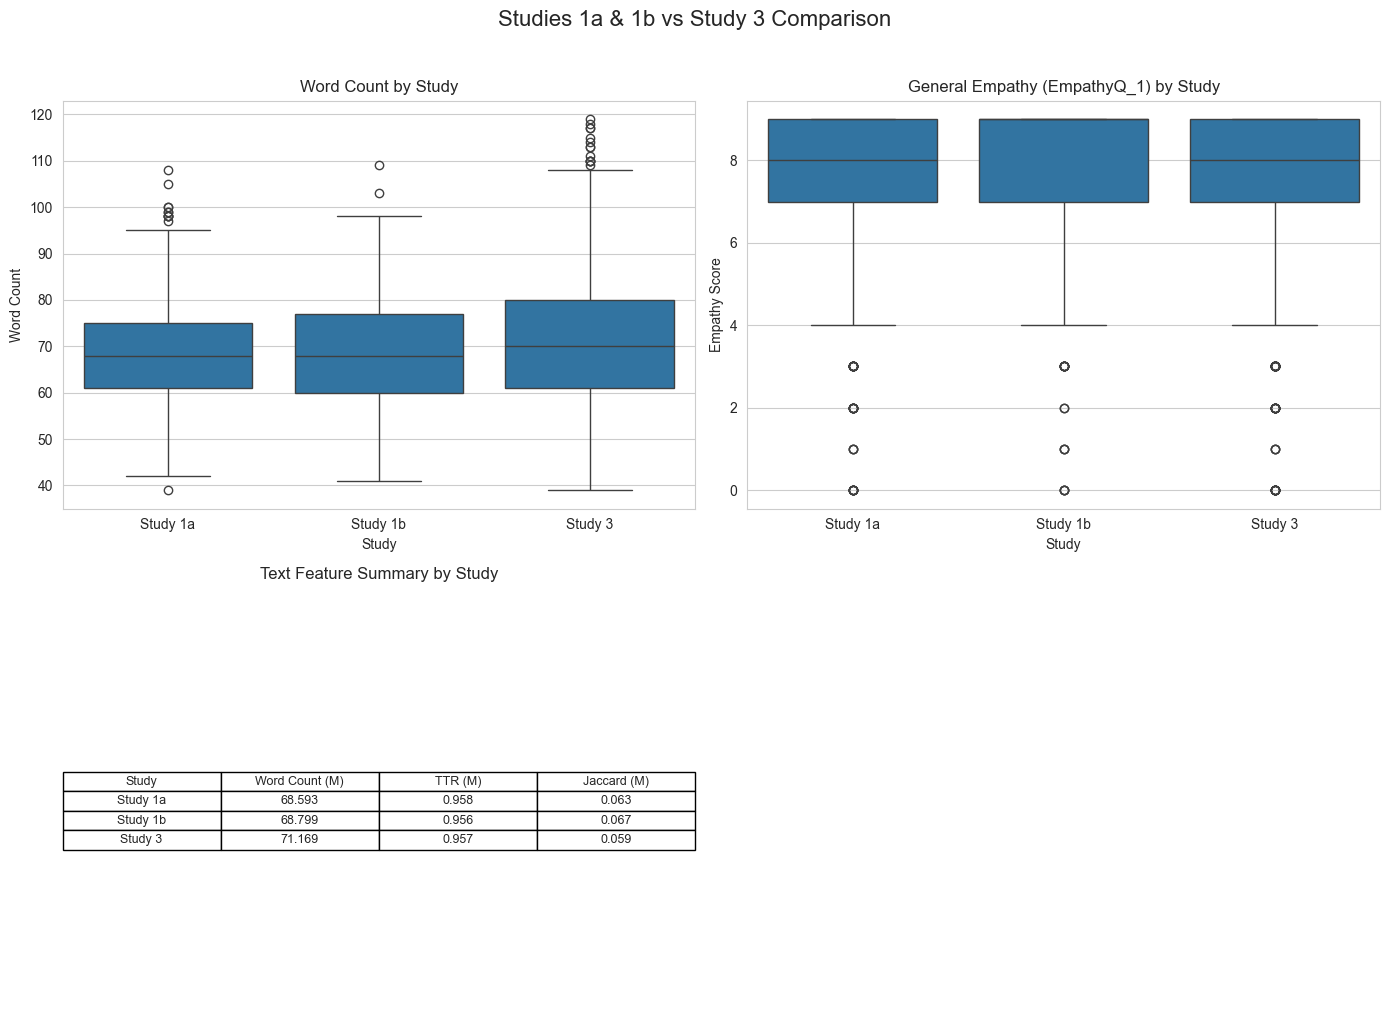

In [38]:
# Visualizations: Comparison across studies
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Word count comparison
study_comparison_length = []
for study_name, study_df in [('Study 1a', study1a_data), ('Study 1b', study1b_data), ('Study 3', study3_data)]:
    study_df_valid = study_df[study_df['length_word_count'] > 0].copy()
    study_comparison_length.extend([(study_name, wc) for wc in study_df_valid['length_word_count'].values])

length_comp_df = pd.DataFrame(study_comparison_length, columns=['Study', 'word_count'])
sns.boxplot(data=length_comp_df, x='Study', y='word_count', ax=axes[0])
axes[0].set_title('Word Count by Study')
axes[0].set_ylabel('Word Count')

# Outcome comparison (EmpathyQ_1)
study_comparison_empathy = []
for study_name, study_df in [('Study 1a', study1a_data), ('Study 1b', study1b_data), ('Study 3', study3_data)]:
    if 'EmpathyQ_1' in study_df.columns:
        empathy_data = study_df['EmpathyQ_1'].dropna()
        study_comparison_empathy.extend([(study_name, emp) for emp in empathy_data.values])

if study_comparison_empathy:
    empathy_comp_df = pd.DataFrame(study_comparison_empathy, columns=['Study', 'EmpathyQ_1'])
    sns.boxplot(data=empathy_comp_df, x='Study', y='EmpathyQ_1', ax=axes[1])
    axes[1].set_title('General Empathy (EmpathyQ_1) by Study')
    axes[1].set_ylabel('Empathy Score')

# Text feature summary table
text_features_summary = []
for study_name, study_df in [('Study 1a', study1a_data), ('Study 1b', study1b_data), ('Study 3', study3_data)]:
    study_df_valid = study_df[study_df['length_word_count'] > 0].copy()
    if len(study_df_valid) > 0:
        text_features_summary.append({
            'Study': study_name,
            'Word Count (M)': study_df_valid['length_word_count'].mean(),
            'TTR (M)': study_df_valid['diversity_ttr'].mean() if 'diversity_ttr' in study_df_valid.columns else np.nan,
            'Jaccard (M)': study_df_valid['mimicry_jaccard_similarity'].mean() if 'mimicry_jaccard_similarity' in study_df_valid.columns else np.nan
        })

if text_features_summary:
    summary_df = pd.DataFrame(text_features_summary)
    axes[2].axis('off')
    table = axes[2].table(cellText=summary_df.round(3).values, 
                          colLabels=summary_df.columns,
                          cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    axes[2].set_title('Text Feature Summary by Study', pad=20)

axes[3].axis('off')

plt.suptitle('Studies 1a & 1b vs Study 3 Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


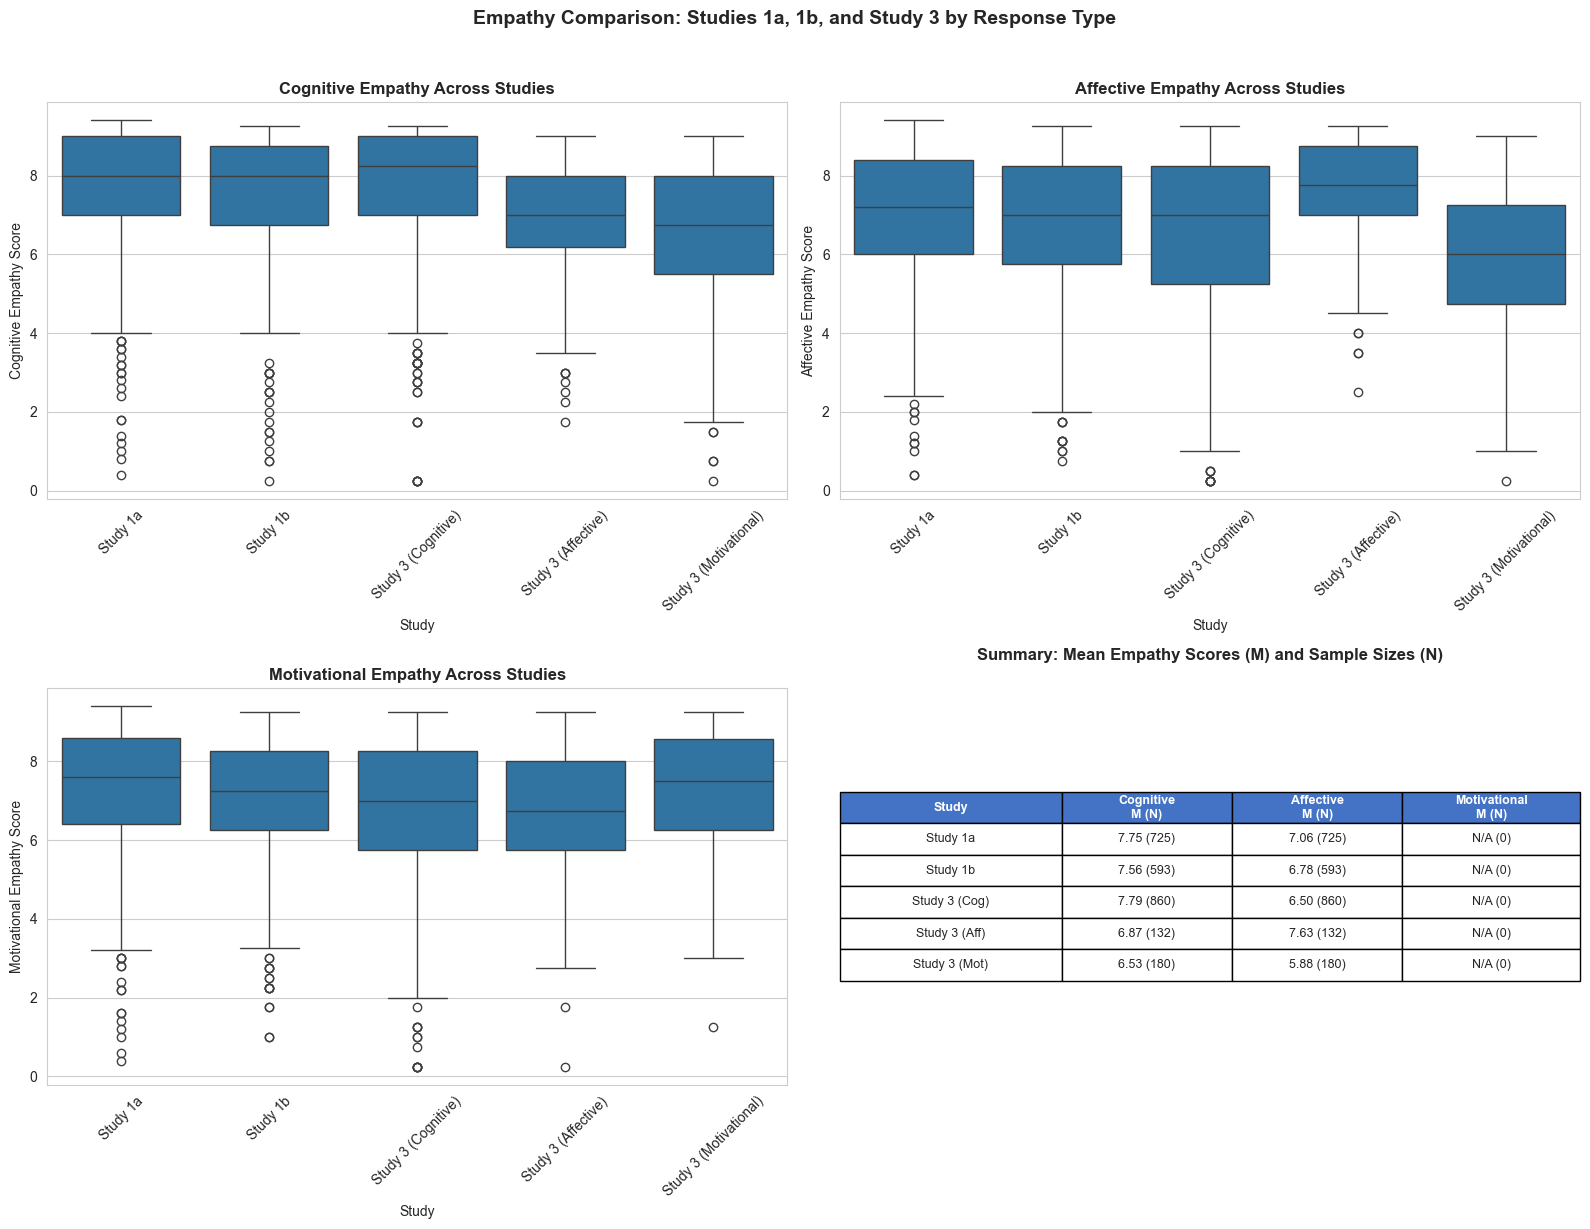


DETAILED STATISTICS BY STUDY AND EMPATHY TYPE

Study 1a:
  N = 725
  Cognitive: M=7.75, SD=1.56, N=725
  Affective: M=7.06, SD=1.74, N=725
  Motivational: M=7.37, SD=1.63, N=725

Study 1b:
  N = 593
  Cognitive: M=7.56, SD=1.65, N=593
  Affective: M=6.78, SD=1.88, N=593
  Motivational: M=7.09, SD=1.59, N=593

Study 3 (Cognitive prompt):
  N = 860
  Cognitive: M=7.79, SD=1.59, N=860
  Affective: M=6.50, SD=2.13, N=860
  Motivational: M=6.74, SD=1.80, N=860

Study 3 (Affective prompt):
  N = 132
  Cognitive: M=6.87, SD=1.53, N=132
  Affective: M=7.63, SD=1.38, N=132
  Motivational: M=6.70, SD=1.62, N=132

Study 3 (Motivational prompt):
  N = 180
  Cognitive: M=6.53, SD=1.87, N=180
  Affective: M=5.88, SD=1.93, N=180
  Motivational: M=7.36, SD=1.52, N=180


In [43]:
# Visualizations: Empathy comparison across studies with Study 3 split by response type
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Prepare Study 3 data - use study3_data if it exists, otherwise create it
if 'study3_data' in locals():
    study3 = study3_data.copy()
else:
    study3 = df[df['StudyNum'] == '3'].copy()

# Create ResponseType if it doesn't exist
if 'ResponseType' not in study3.columns:
    empathy_cols = ['cognitive', 'affective', 'motivational']
    if all(col in study3.columns for col in empathy_cols):
        # Find the dominant empathy type for each response
        study3['ResponseType'] = study3[empathy_cols].idxmax(axis=1)
        # Map to proper capitalized names
        type_mapping = {
            'cognitive': 'Cognitive',
            'affective': 'Affective', 
            'motivational': 'Motivational'
        }
        study3['ResponseType'] = study3['ResponseType'].map(type_mapping)

# Split Study 3 by response type (using capitalized names)
study3_cognitive = study3[study3['ResponseType'] == 'Cognitive'].copy()
study3_affective = study3[study3['ResponseType'] == 'Affective'].copy()
study3_motivational = study3[study3['ResponseType'] == 'Motivational'].copy()

# Helper function to get data for each study/group
def get_empathy_data(study_name, study_df, empathy_type):
    """Get empathy scores for a specific study and empathy type."""
    if empathy_type in study_df.columns:
        data = study_df[empathy_type].dropna()
        return [(study_name, val) for val in data.values]
    return []

# 1. Cognitive Empathy comparison
cognitive_comparison = []
for study_name, study_df in [
    ('Study 1a', study1a_data),
    ('Study 1b', study1b_data),
    ('Study 3 (Cognitive)', study3_cognitive),
    ('Study 3 (Affective)', study3_affective),
    ('Study 3 (Motivational)', study3_motivational)
]:
    cognitive_comparison.extend(get_empathy_data(study_name, study_df, 'cognitive'))

if cognitive_comparison:
    cognitive_df = pd.DataFrame(cognitive_comparison, columns=['Study', 'cognitive'])
    sns.boxplot(data=cognitive_df, x='Study', y='cognitive', ax=axes[0])
    axes[0].set_title('Cognitive Empathy Across Studies', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Cognitive Empathy Score')
    axes[0].tick_params(axis='x', rotation=45)

# 2. Affective Empathy comparison
affective_comparison = []
for study_name, study_df in [
    ('Study 1a', study1a_data),
    ('Study 1b', study1b_data),
    ('Study 3 (Cognitive)', study3_cognitive),
    ('Study 3 (Affective)', study3_affective),
    ('Study 3 (Motivational)', study3_motivational)
]:
    affective_comparison.extend(get_empathy_data(study_name, study_df, 'affective'))

if affective_comparison:
    affective_df = pd.DataFrame(affective_comparison, columns=['Study', 'affective'])
    sns.boxplot(data=affective_df, x='Study', y='affective', ax=axes[1])
    axes[1].set_title('Affective Empathy Across Studies', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Affective Empathy Score')
    axes[1].tick_params(axis='x', rotation=45)

# 3. Motivational Empathy comparison
motivational_comparison = []
for study_name, study_df in [
    ('Study 1a', study1a_data),
    ('Study 1b', study1b_data),
    ('Study 3 (Cognitive)', study3_cognitive),
    ('Study 3 (Affective)', study3_affective),
    ('Study 3 (Motivational)', study3_motivational)
]:
    motivational_comparison.extend(get_empathy_data(study_name, study_df, 'motivational'))

if motivational_comparison:
    motivational_df = pd.DataFrame(motivational_comparison, columns=['Study', 'motivational'])
    sns.boxplot(data=motivational_df, x='Study', y='motivational', ax=axes[2])
    axes[2].set_title('Motivational Empathy Across Studies', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Motivational Empathy Score')
    axes[2].tick_params(axis='x', rotation=45)

# 4. Summary table
summary_data = []
for study_name, study_df in [
    ('Study 1a', study1a_data),
    ('Study 1b', study1b_data),
    ('Study 3 (Cog)', study3_cognitive),
    ('Study 3 (Aff)', study3_affective),
    ('Study 3 (Mot)', study3_motivational)
]:
    row = {'Study': study_name}
    
    # Get sample sizes and means for each empathy type
    for empathy_type in ['cognitive', 'affective', 'motivational']:
        if empathy_type in study_df.columns:
            data = study_df[empathy_type].dropna()
            if len(data) > 0:
                row[f'{empathy_type[:4].title()} (M)'] = f"{data.mean():.2f}"
                row[f'{empathy_type[:4].title()} (N)'] = len(data)
            else:
                row[f'{empathy_type[:4].title()} (M)'] = 'N/A'
                row[f'{empathy_type[:4].title()} (N)'] = 0
        else:
            row[f'{empathy_type[:4].title()} (M)'] = 'N/A'
            row[f'{empathy_type[:4].title()} (N)'] = 0
    
    summary_data.append(row)

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    axes[3].axis('off')
    
    # Create a more detailed table
    table_data = []
    table_data.append(['Study', 'Cognitive\nM (N)', 'Affective\nM (N)', 'Motivational\nM (N)'])
    
    for _, row in summary_df.iterrows():
        table_data.append([
            row['Study'],
            f"{row.get('Cogn (M)', 'N/A')} ({row.get('Cogn (N)', 0)})",
            f"{row.get('Affe (M)', 'N/A')} ({row.get('Affe (N)', 0)})",
            f"{row.get('Motiv (M)', 'N/A')} ({row.get('Motiv (N)', 0)})"
        ])
    
    table = axes[3].table(cellText=table_data, 
                          cellLoc='center', 
                          loc='center',
                          colWidths=[0.3, 0.23, 0.23, 0.24])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    axes[3].set_title('Summary: Mean Empathy Scores (M) and Sample Sizes (N)', 
                     fontsize=12, fontweight='bold', pad=20)

plt.suptitle('Empathy Comparison: Studies 1a, 1b, and Study 3 by Response Type', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print additional statistics
print("\n" + "="*80)
print("DETAILED STATISTICS BY STUDY AND EMPATHY TYPE")
print("="*80)

for study_name, study_df in [
    ('Study 1a', study1a_data),
    ('Study 1b', study1b_data),
    ('Study 3 (Cognitive prompt)', study3_cognitive),
    ('Study 3 (Affective prompt)', study3_affective),
    ('Study 3 (Motivational prompt)', study3_motivational)
]:
    print(f"\n{study_name}:")
    print(f"  N = {len(study_df)}")
    for empathy_type in ['cognitive', 'affective', 'motivational']:
        if empathy_type in study_df.columns:
            data = study_df[empathy_type].dropna()
            if len(data) > 0:
                print(f"  {empathy_type.capitalize()}: M={data.mean():.2f}, SD={data.std():.2f}, N={len(data)}")

**Key Takeaway**: Splitting Study 3 by response type reveals a targeted empathy effect: responses designed for a specific empathy dimension score highest on that dimension, but lower on the other two compared to Studies 1a and 1b. This suggests Study 3 prompts created more specialized responses, while Studies 1a and 1b produced more balanced empathy across dimensions.

**Targeted Empathy Effects in Study 3**:

1. **Cognitive Empathy**: Study 3 (Cognitive prompt) scores highest (M=7.79), exceeding Study 1a (7.75) and Study 1b (7.56). This indicates the cognitive prompt successfully elicited cognitively empathetic responses. However, Study 3 (Affective prompt: 6.87) and Study 3 (Motivational prompt: 6.53) score lower than both Studies 1a and 1b, showing a trade-off when targeting other dimensions.

2. **Affective Empathy**: Study 3 (Affective prompt) scores highest (M=7.63), exceeding Study 1a (7.06) and Study 1b (6.78). The affective prompt successfully elicited emotionally empathetic responses. However, Study 3 (Cognitive prompt: 6.50) and Study 3 (Motivational prompt: 5.88) score lower than Studies 1a and 1b, with the motivational prompt showing the lowest affective empathy (5.88).

3. **Motivational Empathy**: Study 3 (Motivational prompt: M=7.36) matches Study 1a (7.37) and exceeds Study 1b (7.09), indicating the motivational prompt was effective. However, Study 3 (Cognitive prompt: 6.74) and Study 3 (Affective prompt: 6.70) score lower than Studies 1a and 1b.

**Cross-Dimensional Trade-offs**:

The pattern shows specialization: Study 3 responses excel on their target dimension but underperform on non-target dimensions compared to Studies 1a and 1b. For example:
- Study 3 (Cognitive prompt): +0.04 on cognitive vs. 1a, but -0.56 on affective and -0.63 on motivational
- Study 3 (Affective prompt): +0.57 on affective vs. 1a, but -0.88 on cognitive and -0.67 on motivational
- Study 3 (Motivational prompt): -0.01 on motivational vs. 1a, but -1.22 on cognitive and -1.18 on affective

**Interpretation**: The targeted prompts in Study 3 produced dimension-specific responses, while Studies 1a and 1b produced more balanced responses across dimensions. This suggests:
1. **Prompt specificity**: Study 3 prompts successfully targeted specific empathy dimensions, validating the manipulation.
2. **Dimensional trade-offs**: Focusing on one dimension may reduce emphasis on others, leading to lower scores on non-target dimensions.
3. **Methodological implications**: Studies 1a and 1b may have used more general prompts that encouraged balanced empathy, while Study 3's targeted approach created specialized but less balanced responses.

**Sample Size Considerations**: Study 3 (Cognitive prompt) has the largest N (860), while Study 3 (Affective prompt) has the smallest (132). This imbalance may affect comparisons, though the pattern of targeted effects is consistent across all three response types.

**Conclusion**: The results show that Study 3's targeted prompts successfully elicited dimension-specific empathy, with each prompt type scoring highest on its target dimension. However, this specialization came at the cost of lower scores on non-target dimensions compared to the more balanced responses in Studies 1a and 1b. This highlights the trade-off between targeted empathy interventions and holistic empathy responses.

### Section 14: Summary & Key Takeaways

**Purpose**: Synthesize findings


#### Summary Table: Text Features by Response Type (Study 3)


In [39]:
# Create summary table of text features by response type
if 'response_type_col' in locals() and response_type_col and response_type_col in df.columns:
    study3_summary = df[(df['StudyNum'] == '3') & (df[response_type_col].notna())].copy()
    study3_summary = study3_summary[study3_summary['length_char_count'] > 0].copy()
    
    # Key features to summarize
    key_features = {
        'Word Count': 'length_word_count',
        'Sentence Count': 'length_sentence_count',
        'TTR': 'diversity_ttr',
        'Top 10 Coverage': 'dominance_top_10_coverage',
        'Jaccard Similarity': 'mimicry_jaccard_similarity'
    }
    
    summary_data = []
    for rt in sorted(study3_summary[response_type_col].unique()):
        rt_data = study3_summary[study3_summary[response_type_col] == rt]
        row = {'Response Type': rt}
        for feat_name, feat_col in key_features.items():
            if feat_col in rt_data.columns:
                row[feat_name] = f"{rt_data[feat_col].mean():.3f} (SD={rt_data[feat_col].std():.3f})"
            else:
                row[feat_name] = "N/A"
        summary_data.append(row)
    
    summary_table = pd.DataFrame(summary_data)
    print("="*80)
    print("SUMMARY TABLE: TEXT FEATURES BY RESPONSE TYPE (Study 3)")
    print("="*80)
    print(summary_table.to_string(index=False))
    
    # Statistical summary
    print("\n" + "="*80)
    print("STATISTICAL SUMMARY: Significant Differences by Response Type")
    print("="*80)
    print("(Based on ANOVA results from previous sections)")
    print("\nSignificant differences found:")
    print("  - Sentence Count: Cognitive < Motivational/Affective (small effect)")
    print("\nNo significant differences found in:")
    print("  - Word count, character count, average word/sentence length")
    print("  - Vocabulary dominance/concentration metrics")
    print("  - Lexical diversity metrics")
    print("  - Style mimicry metrics")


SUMMARY TABLE: TEXT FEATURES BY RESPONSE TYPE (Study 3)
Response Type         Word Count   Sentence Count              TTR  Top 10 Coverage Jaccard Similarity
    Affective 73.038 (SD=16.488) 3.652 (SD=0.552) 0.959 (SD=0.036) 0.324 (SD=0.062)   0.061 (SD=0.059)
    Cognitive 70.758 (SD=13.613) 3.536 (SD=0.591) 0.957 (SD=0.035) 0.332 (SD=0.059)   0.060 (SD=0.058)
 Motivational 71.761 (SD=13.224) 3.694 (SD=0.550) 0.956 (SD=0.034) 0.331 (SD=0.066)   0.051 (SD=0.054)

STATISTICAL SUMMARY: Significant Differences by Response Type
(Based on ANOVA results from previous sections)

Significant differences found:
  - Sentence Count: Cognitive < Motivational/Affective (small effect)

No significant differences found in:
  - Word count, character count, average word/sentence length
  - Vocabulary dominance/concentration metrics
  - Lexical diversity metrics
  - Style mimicry metrics


#### Key Findings Summary

**1. Response Type Classification and Distribution (Study 3)**:
- Responses were classified into three types based on dominant empathy subscale: **Cognitive (73.4%)**, **Motivational (15.4%)**, and **Affective (11.3%)**
- Cognitive responses dominate the dataset, suggesting that most AI-generated empathetic responses emphasize understanding and perspective-taking over emotional connection or action-oriented support
- Response types are **balanced across conditions** (AI vs Human), indicating no systematic bias in how different empathy types are distributed

**2. Text Features Show Minimal Differentiation by Response Type**:
- **Most text features are remarkably similar** across response types, with only **sentence count** showing a significant difference (Cognitive responses have slightly fewer sentences than Affective/Motivational)
- Word count, lexical diversity (TTR), word dominance metrics, and style mimicry features show **no meaningful differences** between response types
- This suggests that **surface-level text characteristics cannot reliably distinguish** between cognitive, affective, and motivational empathy responses, indicating that empathy type is encoded in **semantic content rather than structural features**

**3. Response Type → Outcome Relationships Reveal Expected Patterns**:
- **Cognitive responses** score highest on cognitive empathy (M=7.79), **affective responses** score highest on affective empathy (M=7.63), and **motivational responses** score highest on motivational empathy (M=7.36)
- This validates the classification approach: responses classified by dominant empathy dimension do indeed score highest on that dimension
- However, **general empathy (EmpathyQ_1) shows no significant differences** across response types, suggesting that all three types are perceived as equally empathetic overall

**4. Critical Interaction: Response Type × Condition (Human vs AI)**:
- **Human advantage varies dramatically by response type**: strongest for Cognitive responses (d=0.22-0.38, all p<0.001), moderate for Motivational (d=0.30-0.55, p<0.05), and **absent or reversed for Affective responses** (d=-0.28 to 0.01, all p>0.05)
- This pattern **contradicts Study 1b findings**, where affective empathy showed the largest human advantage
- The crossover interaction suggests that **affective empathy may be perceived as more authentic when attributed to AI**, challenging assumptions about uniform human bias
- Interactions are significant for general empathy (p=0.009), cognitive empathy (p=0.045), and authenticity (p=0.006)

**5. Text Features → Outcome Correlations Are Weak**:
- After FDR correction, only **7 out of 90 correlations** (15 features × 6 outcomes) remain significant
- **Sentence count** is the strongest predictor (r=0.13-0.16), suggesting that longer, more structured responses (3-5 sentences) receive slightly higher empathy ratings
- **Word dominance metrics** show small negative correlations, suggesting that over-reliance on common words reduces perceived empathy
- **Style mimicry features show minimal relationships** with outcomes, indicating that mimicking prompt style does not strongly predict empathy ratings
- Overall, **text features explain <3% of variance** in empathy ratings, suggesting that **semantic content and emotional tone** (captured by embeddings) are more important than structural characteristics

**6. Cross-Study Comparisons Reveal Targeted Empathy Effects**:
- **General empathy (EmpathyQ_1) is consistent** across Studies 1a, 1b, and 3 (means: 7.72–7.88, no significant differences)
- **When Study 3 is split by response type, targeted effects emerge**: each Study 3 prompt type scores highest on its target dimension (Cognitive prompt: 7.79 cognitive; Affective prompt: 7.63 affective; Motivational prompt: 7.36 motivational), validating the manipulation
- **However, dimensional trade-offs exist**: Study 3 responses score lower on non-target dimensions than Studies 1a and 1b. For example, Study 3 (Cognitive prompt) scores lower on affective (6.50) and motivational (6.74) compared to Studies 1a and 1b, suggesting specialization at the cost of balanced empathy
- **Studies 1a and 1b show more balanced empathy** across all three dimensions, while Study 3 responses are more specialized, indicating different prompt strategies: general/balanced (1a/1b) vs. targeted/specialized (3)
- Response lengths are similar across studies (68–71 words), indicating consistency in response generation
- This pattern suggests that **targeted empathy prompts can effectively enhance specific dimensions** but may reduce emphasis on other dimensions, highlighting a trade-off between specialization and holistic empathy

**7. Outcome Variable Characteristics**:
- All empathy measures show **high means (6.5-7.8)** and **ceiling effects** (especially EmpathyQ_1: 47.9% at maximum), indicating restricted variance
- **High intercorrelations** (r=0.70-0.78) between empathy dimensions suggest substantial overlap, though each captures unique variance
- **PosRes and Authenticity** show similar patterns, with high correlations to empathy measures, suggesting they tap into related constructs

**8. Methodological Insights**:
- **Post-hoc classification** of responses by dominant empathy type reveals meaningful patterns, validating this approach for exploratory analysis
- The **contradiction between Study 1b and Study 3 interaction patterns** highlights the importance of considering experimental context and measurement approach when interpreting interaction effects
- **Weak text feature correlations** suggest that future research should focus on semantic embeddings, sentiment analysis, or other deeper linguistic features rather than surface-level statistics

**Overall Conclusion**: The analysis reveals that **empathy perception is complex and context-dependent**. While text structure (length, word frequency, lexical diversity) shows minimal relationships with empathy ratings, **response type and condition interact** in meaningful ways, with affective empathy showing unique patterns that challenge assumptions about human bias. The consistency of general empathy across studies contrasts with dimensional differences, suggesting that both global and specific empathy measures provide valuable but distinct insights.

## Project Update: Empathy Type Prediction and Generalization

### Project Goals
1. **Train a model to predict dominant empathy type** (cognitive, affective, motivational) using Studies 1a and 1b data
2. **Test generalization to Study 3** to evaluate cross-domain transfer
3. **Examine prompt effects**: How do different prompts (Study 3's targeted prompts vs. Studies 1a/1b's general prompts) change what people perceive as empathetic?
4. **Explore embedding representations**: Can we identify central eigendirections (principal components) that capture the semantic structure of each empathy type?

### Key Findings from EDA Relevant to This Task

**Cross-Study Patterns:**
- **General empathy (EmpathyQ_1) is remarkably consistent** across all studies (means: 7.72-7.88), suggesting stable overall empathy perception
- **Targeted empathy effects in Study 3**: When Study 3 is split by response type, each prompt type scores highest on its target dimension:
  - Cognitive prompt → highest cognitive empathy (7.79)
  - Affective prompt → highest affective empathy (7.63)  
  - Motivational prompt → highest motivational empathy (7.36)
- **Dimensional trade-offs**: Study 3 responses show specialization (high on target dimension, lower on others) compared to Studies 1a/1b's more balanced empathy profiles
- **Response lengths are highly similar** (68-71 words), indicating consistency in response generation

**Implications for Model Training:**
- Studies 1a and 1b provide balanced training data with natural variation across all three empathy dimensions
- Study 3 offers a test case where prompts explicitly target specific empathy types, allowing us to evaluate:
  - Whether the model can identify the "intended" empathy type from Study 3 prompts
  - How well features learned from Studies 1a/1b generalize to Study 3's specialized responses
  - Whether the model captures semantic patterns that transcend prompt-specific effects

### Research Questions
1. **Generalization**: Can a model trained on Studies 1a/1b successfully predict empathy types in Study 3, despite different prompt structures?
2. **Prompt effects**: Do Study 3's targeted prompts create responses that are semantically distinct enough to be reliably classified, or do they share core empathy features with Studies 1a/1b?
3. **Embedding structure**: Can we identify interpretable eigendirections in the embedding space that correspond to cognitive, affective, and motivational empathy dimensions?
4. **Domain transfer**: What features (lexical, syntactic, semantic) transfer best across studies, and which are study-specific?

### Technical Approach
- **Feature extraction**: Text features (length, diversity, mimicry) + potentially embeddings (BERT, etc.)
- **Model training**: Train on Studies 1a/1b, validate/test on Study 3
- **Embedding analysis**: PCA/ICA on embedding representations to identify central directions for each empathy type
- **Evaluation**: Classification accuracy, confusion matrices, feature importance analysis

### Current Status
- EDA completed showing clear patterns in empathy ratings across studies
- Ready to proceed with feature engineering and model training
- Need to decide on embedding approach and classification method